In [ ]:
import numpy as np
import chess
import chess.pgn
import math
import random
from collections import defaultdict, deque
from tensorflow.keras.models import Sequential 
from tensorflow.keras.models import load_model

C_PUCT = 2.8      
model_type = "agressive"
model = load_model(f'{model_type}.keras')

import numpy as np
piece_map = {
    chess.PAWN: 0,
    chess.KNIGHT: 1,
    chess.BISHOP: 2,
    chess.ROOK: 3,
    chess.QUEEN: 4,
    chess.KING: 5
}
def board2tensor_1d(board):
    tensor = np.zeros((12, 64), dtype=np.float32)
    for sq in chess.SQUARES:
        piece = board.piece_at(sq)
        if piece:
            base = piece_map[piece.piece_type]
            if piece.color == chess.BLACK:
                base += 6
            tensor[base, sq] = 1.0
    return tensor.flatten()
def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)


class MCTSNode:
    def __init__(self, board, parent=None, eval=0.0, prior=0.0):
        self.board = board.copy()
        self.parent = parent
        self.children = {}
        self.prior = eval
        self.eval = eval
        self.N = 0
        self.W = 0.0
        self.Q = 0.0
        self.is_expanded = False

    def expand(self):
        legal_moves = list(self.board.generate_legal_moves())
        n = len(legal_moves)

        turn = 1.0
        if self.board.turn: 
            turn = -1.0

        tensors = np.zeros((n, 12 * 64), dtype=np.float32)
        for i, move in enumerate(legal_moves):
            self.board.push(move)
            tensors[i] = board2tensor_1d(self.board)
            self.board.pop()

        evals = model.predict(tensors, verbose=0).flatten()
        evals *= turn
        priors = softmax(evals)
        for move, ev, p in zip(legal_moves, evals, priors):
            self.children[move] = MCTSNode(
                board=self.board,
                parent=self,
                eval=ev,
                prior=p
            )

        self.is_expanded = True
        return self.eval

    @staticmethod
    def uct_score(child, parent_N, c_puct=1.5):
        U = c_puct * child.prior * math.sqrt(parent_N + 1e-8) / (1 + child.N)
        return child.Q + U


    def select_child(self):
        parent_N = self.N
        best_move = None
        best_score = -float('inf')

        for move, child in self.children.items():
            score = MCTSNode.uct_score(child, parent_N)
            if score > best_score:
                best_score = score
                best_move = move

        return best_move, self.children[best_move]

    def backpropagate(self, value):
        node = self
        while node is not None:
            node.N += 1
            node.W += value
            node.Q = node.W / node.N
            
            value = -value
            node = node.parent

    def get_policy_value(self):
        policy = self.Q
        if not self.board.turn:  # przywrucenie widoku ze strony białych
            policy *= -1
        return policy


def mcts_search(root, simulations=200):
    for _ in range(simulations):
        node = root

        # Selection
        while node.is_expanded and not node.board.is_game_over():
            move, node = node.select_child()

        # Expansion
        if not node.board.is_game_over():
            value = node.expand()
        else:
            result = node.board.result()
            if result == "1-0":
                value = 5000
            elif result == "0-1":
                value = -5000
            else:
                value = 0

        # Backpropagation
        node.backpropagate(value)


2025-12-18 18:14:17.552201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766078057.568457   18650 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766078057.575066   18650 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766078057.670046   18650 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766078057.670071   18650 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766078057.670073   18650 computation_placer.cc:177] computation placer alr

In [2]:
from collections import deque

def extract_training_data(root):
    queue = deque([root])
    X, Y = [], []

    while queue:
        node = queue.popleft()

        tensor = board2tensor_1d(node.board)
        X.append(tensor)

        # Q-value jako label
        Y.append(node.get_policy_value())

        for child in node.children.values():
            queue.append(child)

    return np.array(X), np.array(Y)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
model = load_model(f'{model_type}.keras')
ITERATIONS = 150
SYMULATIONS = 600

version = 1
historis = []
for iter in range(ITERATIONS):
    root = MCTSNode(chess.Board())
    mcts_search(root, simulations=SYMULATIONS)
    X, Y = extract_training_data(root)

    X = np.array(X)
    Y = np.array(Y).astype(np.float32)
    print("Zebrano przykładów:", X.shape[0])


    X_train, X_val, y_train, y_val = train_test_split(
        X, Y, test_size=0.2, shuffle=True
    )


    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"]
    )
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=256,
        verbose=1,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )
    historis.append(history)
    if((iter + 1) % 10 == 0):
        model.save(f"models/{model_type}_{version}.keras")
        version += 1





Zebrano przykładów: 17697
Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0025 - mae: 0.0311 - val_loss: 8.6595e-05 - val_mae: 0.0067
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2909e-05 - mae: 0.0044 - val_loss: 4.2890e-05 - val_mae: 0.0035
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0124e-05 - mae: 0.0035 - val_loss: 3.8419e-05 - val_mae: 0.0031
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7001e-05 - mae: 0.0032 - val_loss: 3.6443e-05 - val_mae: 0.0030
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5234e-05 - mae: 0.0031 - val_loss: 3.4167e-05 - val_mae: 0.0028
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3054e-05 - mae: 0.0028 - val_loss: 3.2375e-05 - val_mae: 0.0026
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2183e-05 - mae: 0.0027 - val_loss: 3.3840e-05 - val_mae: 0.0027
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1227e-05 - mae: 0.0027 - val_loss: 3.3219e-05 - v

2025-12-18 21:15:32.424120: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 21:15:32.758557: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 21:15:32.785858: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 636 bytes spill stores, 636 bytes spill loads

2025-12-18 21:15:32.787461: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 492 bytes spill stores, 492 bytes spill loads

2025-12-18 21:15:32.858806: I external

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0016 - mae: 0.0273

2025-12-18 21:15:34.393585: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 21:15:34.441995: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 21:15:34.502926: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 21:15:34.608554: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-18 21:15:34.638206: I external/loc

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 6.8804e-04 - mae: 0.0159 - val_loss: 2.6407e-05 - val_mae: 0.0037
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3929e-05 - mae: 0.0023 - val_loss: 1.1329e-05 - val_mae: 0.0018
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8168e-06 - mae: 0.0017 - val_loss: 1.0286e-05 - val_mae: 0.0017
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9215e-06 - mae: 0.0016 - val_loss: 9.5048e-06 - val_mae: 0.0015
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5568e-06 - mae: 0.0015 - val_loss: 1.1095e-05 - val_mae: 0.0018
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1812e-06 - mae: 0.0015 - val_loss: 8.7036e-06 - val_mae: 0.0014
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1490e-06 - mae: 0.0015 - val_loss: 8.9377e-06 - val_mae: 0.0015
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1999e-06 - mae: 0.0015 - val_loss: 8.6665e-06 - val_mae: 0.0015
Epoch 9/10
63/63 ━

2025-12-18 21:25:29.837208: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 21:25:30.132785: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 21:25:30.186419: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-18 21:25:30.200641: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 232 bytes spill stores, 232 bytes spill loads

2025-12-18 21:25:30.275938: I external/local

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0020 - mae: 0.0291

2025-12-18 21:25:32.191471: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 21:25:32.220499: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-18 21:25:32.380792: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-18 21:25:32.403457: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-18 21:25:32.611147: I external/l

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 8.3565e-04 - mae: 0.0179 - val_loss: 3.1013e-05 - val_mae: 0.0044
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4774e-05 - mae: 0.0028 - val_loss: 1.0157e-05 - val_mae: 0.0023
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0205e-06 - mae: 0.0019 - val_loss: 6.3518e-06 - val_mae: 0.0017
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7581e-06 - mae: 0.0015 - val_loss: 4.8303e-06 - val_mae: 0.0015
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4589e-06 - mae: 0.0013 - val_loss: 4.0750e-06 - val_mae: 0.0013
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9042e-06 - mae: 0.0012 - val_loss: 3.6054e-06 - val_mae: 0.0013
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3858e-06 - mae: 0.0011 - val_loss: 2.9636e-06 - val_mae: 0.0011
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9441e-06 - mae: 9.4652e-04 - val_loss: 2.4219e-06 - val_mae: 9.6744e-04
Epoch 9/10

2025-12-18 21:35:56.759884: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 21:35:56.767419: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 68 bytes spill stores, 68 bytes spill loads

2025-12-18 21:35:56.967924: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 412 bytes spill stores, 412 bytes spill loads



56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0012 - mae: 0.0235

2025-12-18 21:35:58.066119: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 21:35:58.084940: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 21:35:58.167922: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 21:35:58.289155: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-18 21:35:58.303198: I external/loc

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 5.2030e-04 - mae: 0.0141 - val_loss: 1.4627e-05 - val_mae: 0.0028
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0756e-05 - mae: 0.0024 - val_loss: 5.0429e-06 - val_mae: 0.0016
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0477e-06 - mae: 0.0014 - val_loss: 3.9557e-06 - val_mae: 0.0014
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0306e-06 - mae: 0.0012 - val_loss: 3.1980e-06 - val_mae: 0.0012
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5047e-06 - mae: 0.0011 - val_loss: 2.8414e-06 - val_mae: 0.0012
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0233e-06 - mae: 9.5796e-04 - val_loss: 2.2576e-06 - val_mae: 9.9535e-04
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8992e-06 - mae: 9.1885e-04 - val_loss: 2.7257e-06 - val_mae: 0.0011
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9180e-06 - mae: 9.4066e-04 - val_loss: 4.3451e-06 - val_mae: 0.0016
Ep

2025-12-18 21:46:24.435113: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 21:46:24.442588: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 21:46:24.556975: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 21:46:24.614243: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-18 21:46:24.646057: I external/loc

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0019 - mae: 0.0280

2025-12-18 21:46:26.475780: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 21:46:26.528994: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 21:46:26.547839: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 21:46:26.671464: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-18 21:46:26.702935: I external/local

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 7.5411e-04 - mae: 0.0167 - val_loss: 1.9761e-05 - val_mae: 0.0034
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1295e-05 - mae: 0.0024 - val_loss: 6.7918e-06 - val_mae: 0.0019
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0761e-06 - mae: 0.0016 - val_loss: 4.2092e-06 - val_mae: 0.0014
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3738e-06 - mae: 0.0013 - val_loss: 3.2660e-06 - val_mae: 0.0012
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4714e-06 - mae: 0.0011 - val_loss: 2.5011e-06 - val_mae: 0.0011
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9479e-06 - mae: 9.8434e-04 - val_loss: 2.1676e-06 - val_mae: 0.0010
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6343e-06 - mae: 8.9747e-04 - val_loss: 1.7961e-06 - val_mae: 8.8908e-04
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3979e-06 - mae: 8.2495e-04 - val_loss: 1.5872e-06 - val_mae: 8.5896e-0

2025-12-18 21:57:19.990442: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 21:57:20.088231: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 21:57:20.368124: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 112 bytes spill stores, 112 bytes spill loads

2025-12-18 21:57:20.472914: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 208 bytes spill stores, 208 bytes spill loads

2025-12-18 21:57:20.481248: I external

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0017 - mae: 0.0267

2025-12-18 21:57:21.940986: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 21:57:21.982144: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 21:57:22.011237: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 21:57:22.168306: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-18 21:57:22.205452: I external/l

58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 6.6389e-04 - mae: 0.0155 - val_loss: 2.0713e-05 - val_mae: 0.0033
Epoch 2/10
44/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7627e-05 - mae: 0.0031 

2025-12-18 21:57:22.516270: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3562e-05 - mae: 0.0027 - val_loss: 9.7725e-06 - val_mae: 0.0022
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3595e-06 - mae: 0.0019 - val_loss: 6.6373e-06 - val_mae: 0.0018
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0613e-06 - mae: 0.0015 - val_loss: 4.7427e-06 - val_mae: 0.0015
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1180e-06 - mae: 0.0014 - val_loss: 3.8718e-06 - val_mae: 0.0013
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6654e-06 - mae: 0.0013 - val_loss: 3.4285e-06 - val_mae: 0.0013
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1695e-06 - mae: 0.0012 - val_loss: 2.5790e-06 - val_mae: 0.0010
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7787e-06 - mae: 0.0010 - val_loss: 2.5112e-06 - val_mae: 9.7991e-04
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6679e-06 - mae: 0.0010 - val_loss: 3.7766e-06 - val_mae: 0.0013
Epoch 10/10
58/

2025-12-18 22:07:35.234159: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 22:07:35.533919: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-18 22:07:35.563664: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 22:07:35.573812: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-18 22:07:35.601463: I external/local

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0020 - mae: 0.0290

2025-12-18 22:07:36.980509: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 22:07:37.008449: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 22:07:37.040135: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 22:07:37.212773: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-18 22:07:37.214125: I external/local

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 8.1942e-04 - mae: 0.0178 - val_loss: 4.0482e-05 - val_mae: 0.0053
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2748e-05 - mae: 0.0027 - val_loss: 7.7184e-06 - val_mae: 0.0020
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3048e-06 - mae: 0.0017 - val_loss: 4.9070e-06 - val_mae: 0.0016
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6510e-06 - mae: 0.0014 - val_loss: 3.8296e-06 - val_mae: 0.0014
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6253e-06 - mae: 0.0012 - val_loss: 3.0030e-06 - val_mae: 0.0012
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0807e-06 - mae: 0.0011 - val_loss: 2.3815e-06 - val_mae: 0.0010
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6939e-06 - mae: 9.5124e-04 - val_loss: 2.2197e-06 - val_mae: 0.0010
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4616e-06 - mae: 8.8564e-04 - val_loss: 1.9151e-06 - val_mae: 9.3392e-04
Epoch 

2025-12-18 22:18:33.232497: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 22:18:33.255730: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 22:18:33.625289: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 22:18:33.707442: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-18 22:18:33.790062: I external/l

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0011 - mae: 0.0221

2025-12-18 22:18:35.654053: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 22:18:35.695310: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 22:18:35.729701: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 22:18:35.817454: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-18 22:18:35.853449: I external/l

58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 4.4052e-04 - mae: 0.0125 - val_loss: 6.3147e-06 - val_mae: 0.0018
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7694e-06 - mae: 0.0013 - val_loss: 2.4418e-06 - val_mae: 0.0010
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8346e-06 - mae: 9.0161e-04 - val_loss: 1.5906e-06 - val_mae: 8.0691e-04
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2966e-06 - mae: 7.5421e-04 - val_loss: 1.1710e-06 - val_mae: 6.9547e-04
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0175e-06 - mae: 6.6099e-04 - val_loss: 9.6848e-07 - val_mae: 6.3412e-04
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1856e-07 - mae: 5.6980e-04 - val_loss: 7.7308e-07 - val_mae: 5.3397e-04
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9404e-07 - mae: 5.1792e-04 - val_loss: 7.0564e-07 - val_mae: 5.2093e-04
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5262e-07 - mae: 4.9692e-04 - val_loss: 6.3

2025-12-18 22:30:08.303286: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 22:30:08.579165: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-18 22:30:08.608436: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 192 bytes spill stores, 192 bytes spill loads

2025-12-18 22:30:08.613652: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-18 22:30:08.645146: I external/loc

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 6.9238e-04 - mae: 0.0177

2025-12-18 22:30:10.602718: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 22:30:10.625084: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 22:30:10.664542: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 22:30:10.829137: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-18 22:30:10.841367: I external/local

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 2.7821e-04 - mae: 0.0102 - val_loss: 1.1116e-05 - val_mae: 0.0026
Epoch 2/10
41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4114e-06 - mae: 0.0021 

2025-12-18 22:30:11.102346: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4364e-06 - mae: 0.0017 - val_loss: 3.1852e-06 - val_mae: 0.0013
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4340e-06 - mae: 0.0011 - val_loss: 1.7985e-06 - val_mae: 9.6385e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6427e-06 - mae: 9.2239e-04 - val_loss: 1.2977e-06 - val_mae: 8.1000e-04
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1989e-06 - mae: 7.9465e-04 - val_loss: 1.1034e-06 - val_mae: 7.7624e-04
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1382e-06 - mae: 7.8984e-04 - val_loss: 9.4842e-07 - val_mae: 7.0429e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5604e-07 - mae: 7.2659e-04 - val_loss: 9.2778e-07 - val_mae: 6.7982e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1206e-07 - mae: 7.1152e-04 - val_loss: 6.6382e-07 - val_mae: 5.8992e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0698e-06 - mae: 7.9276e-04 - val_loss: 

2025-12-18 22:41:32.188892: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 22:41:32.439631: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 22:41:32.472211: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-18 22:41:32.606331: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 22:41:32.608768: I external/loc

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0016 - mae: 0.0267

2025-12-18 22:41:34.306163: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 22:41:34.309847: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 22:41:34.339540: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 22:41:34.525411: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-18 22:41:34.530248: I external/local

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 6.6451e-04 - mae: 0.0159 - val_loss: 1.9216e-05 - val_mae: 0.0034
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0080e-05 - mae: 0.0023 - val_loss: 6.5848e-06 - val_mae: 0.0019
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0090e-06 - mae: 0.0017 - val_loss: 4.4179e-06 - val_mae: 0.0015
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3067e-06 - mae: 0.0013 - val_loss: 2.9963e-06 - val_mae: 0.0013
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2512e-06 - mae: 0.0011 - val_loss: 2.3469e-06 - val_mae: 0.0011
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7637e-06 - mae: 9.7181e-04 - val_loss: 1.7053e-06 - val_mae: 9.1568e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3496e-06 - mae: 8.4035e-04 - val_loss: 1.4066e-06 - val_mae: 8.3604e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0981e-06 - mae: 7.5817e-04 - val_loss: 1.2124e-06 - val_mae: 7.774

2025-12-18 22:53:47.108019: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-18 22:53:47.285302: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-18 22:53:47.318826: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-18 22:53:47.348632: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-18 22:53:47.368551: I extern

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0030 - mae: 0.0351

2025-12-18 22:53:48.840077: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 22:53:48.854127: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 68 bytes spill stores, 68 bytes spill loads



65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0011 - mae: 0.0195 - val_loss: 1.8760e-05 - val_mae: 0.0033
Epoch 2/10
 1/65 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9675e-05 - mae: 0.0034

2025-12-18 22:53:49.086820: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 492 bytes spill stores, 492 bytes spill loads



65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1779e-05 - mae: 0.0025 - val_loss: 8.5484e-06 - val_mae: 0.0021
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2768e-06 - mae: 0.0018 - val_loss: 5.7931e-06 - val_mae: 0.0017
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3850e-06 - mae: 0.0015 - val_loss: 4.3137e-06 - val_mae: 0.0014
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2713e-06 - mae: 0.0013 - val_loss: 4.2078e-06 - val_mae: 0.0015
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8377e-06 - mae: 0.0012 - val_loss: 3.0181e-06 - val_mae: 0.0012
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2369e-06 - mae: 0.0011 - val_loss: 2.5912e-06 - val_mae: 0.0011
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7776e-06 - mae: 9.3738e-04 - val_loss: 2.3879e-06 - val_mae: 0.0010
Epoch 9/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5548e-06 - mae: 8.7348e-04 - val_loss: 2.2131e-06 - val_mae: 0.0010
Epoch 10/10

2025-12-18 23:04:55.119517: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-18 23:04:55.141775: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 64 bytes spill stores, 64 bytes spill loads

2025-12-18 23:04:55.228062: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-18 23:04:55.256692: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 456 bytes spill stores, 456 bytes spill loads

2025-12-18 23:04:55.262000: I external/l

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 7.0318e-04 - mae: 0.0160 - val_loss: 1.6183e-05 - val_mae: 0.0030
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0774e-05 - mae: 0.0024 - val_loss: 7.4689e-06 - val_mae: 0.0019
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4818e-06 - mae: 0.0017 - val_loss: 4.6846e-06 - val_mae: 0.0015
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7743e-06 - mae: 0.0014 - val_loss: 3.7548e-06 - val_mae: 0.0013
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8400e-06 - mae: 0.0012 - val_loss: 3.1487e-06 - val_mae: 0.0012
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4899e-06 - mae: 0.0011 - val_loss: 2.3818e-06 - val_mae: 0.0011
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9744e-06 - mae: 9.6475e-04 - val_loss: 2.1565e-06 - val_mae: 9.7867e-04
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7341e-06 - mae: 9.0610e-04 - val_loss: 1.9157e-06 - val_mae: 9.2602e-04
Ep

2025-12-18 23:17:13.111965: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 23:17:13.128520: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 23:17:13.306673: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-18 23:17:13.444025: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-18 23:17:13.466234: I external/local

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0018 - mae: 0.0270

2025-12-18 23:17:15.335417: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 23:17:15.366787: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-18 23:17:15.490964: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-18 23:17:15.526917: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-18 23:17:15.693205: I external/l

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 6.7349e-04 - mae: 0.0151 - val_loss: 2.0742e-05 - val_mae: 0.0034
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0803e-05 - mae: 0.0024 - val_loss: 7.8914e-06 - val_mae: 0.0020
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2410e-06 - mae: 0.0016 - val_loss: 4.7039e-06 - val_mae: 0.0015
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3413e-06 - mae: 0.0013 - val_loss: 3.4208e-06 - val_mae: 0.0012
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4956e-06 - mae: 0.0011 - val_loss: 2.7999e-06 - val_mae: 0.0011
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8615e-06 - mae: 9.3556e-04 - val_loss: 2.1534e-06 - val_mae: 9.5277e-04
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5378e-06 - mae: 8.4834e-04 - val_loss: 1.8813e-06 - val_mae: 9.2757e-04
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3847e-06 - mae: 8.0830e-04 - val_loss: 1.6196e-06 - val_mae: 8.194

2025-12-18 23:28:06.308333: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 23:28:06.560689: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 23:28:06.612631: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 152 bytes spill stores, 152 bytes spill loads

2025-12-18 23:28:06.618511: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 23:28:06.714640: I external/l

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0019 - mae: 0.0279

2025-12-18 23:28:08.479740: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 23:28:08.508127: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-18 23:28:08.649028: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-18 23:28:08.671514: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-18 23:28:08.806137: I external/l

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 7.2539e-04 - mae: 0.0162 - val_loss: 1.8712e-05 - val_mae: 0.0032
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1686e-05 - mae: 0.0025 - val_loss: 7.1719e-06 - val_mae: 0.0019
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6358e-06 - mae: 0.0017 - val_loss: 4.6053e-06 - val_mae: 0.0015
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8951e-06 - mae: 0.0014 - val_loss: 3.5648e-06 - val_mae: 0.0013
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7667e-06 - mae: 0.0012 - val_loss: 2.6952e-06 - val_mae: 0.0012
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1005e-06 - mae: 0.0010 - val_loss: 2.0809e-06 - val_mae: 9.8566e-04
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8191e-06 - mae: 9.6526e-04 - val_loss: 1.7773e-06 - val_mae: 9.1146e-04
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4658e-06 - mae: 8.4719e-04 - val_loss: 1.6601e-06 - val_mae: 9.0322e-0

2025-12-18 23:39:39.478652: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 23:39:39.502096: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 68 bytes spill stores, 68 bytes spill loads

2025-12-18 23:39:39.714750: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 444 bytes spill stores, 444 bytes spill loads



63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016 - mae: 0.0260

2025-12-18 23:39:40.846964: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 23:39:40.853564: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 23:39:40.898105: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 23:39:41.059919: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-18 23:39:41.092586: I external/l

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 6.3186e-04 - mae: 0.0148 - val_loss: 1.5268e-05 - val_mae: 0.0028
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8841e-06 - mae: 0.0023 - val_loss: 8.2410e-06 - val_mae: 0.0020
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3379e-06 - mae: 0.0016 - val_loss: 5.4449e-06 - val_mae: 0.0016
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7337e-06 - mae: 0.0014 - val_loss: 6.3139e-06 - val_mae: 0.0019
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4937e-06 - mae: 0.0014 - val_loss: 3.4890e-06 - val_mae: 0.0013
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2322e-06 - mae: 0.0010 - val_loss: 3.0715e-06 - val_mae: 0.0012
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0537e-06 - mae: 0.0010 - val_loss: 3.6033e-06 - val_mae: 0.0015
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9374e-06 - mae: 9.9516e-04 - val_loss: 2.3408e-06 - val_mae: 0.0011
Epoch 9/10
63/

2025-12-18 23:50:07.111076: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 23:50:07.183038: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 23:50:07.280735: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 23:50:07.434486: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 23:50:07.468529: I external/l

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0019 - mae: 0.0288

2025-12-18 23:50:09.423460: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 23:50:09.491585: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 23:50:09.518730: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 23:50:09.635107: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-18 23:50:09.665208: I external/loc

55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 8.0360e-04 - mae: 0.0168 - val_loss: 4.6075e-05 - val_mae: 0.0052
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3744e-05 - mae: 0.0026 - val_loss: 3.2596e-05 - val_mae: 0.0029
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3207e-05 - mae: 0.0027 - val_loss: 1.4556e-05 - val_mae: 0.0018
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9258e-05 - mae: 0.0023 - val_loss: 1.3996e-05 - val_mae: 0.0018
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1946e-05 - mae: 0.0014 - val_loss: 2.8626e-05 - val_mae: 0.0034
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9200e-05 - mae: 0.0024 - val_loss: 2.5975e-05 - val_mae: 0.0032
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3371e-05 - mae: 0.0020 - val_loss: 3.0614e-05 - val_mae: 0.0029
Zebrano przykładów: 16667
Epoch 1/10
43/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018 - mae: 0.0292       

2025-12-18 23:59:56.295863: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 48 bytes spill stores, 48 bytes spill loads

2025-12-18 23:59:56.485308: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 23:59:56.509128: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 32 bytes spill stores, 32 bytes spill loads

2025-12-18 23:59:56.565390: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-18 23:59:56.569911: I external/l

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 6.6268e-04 - mae: 0.0161 - val_loss: 1.5761e-05 - val_mae: 0.0031
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7230e-06 - mae: 0.0020 - val_loss: 5.6634e-06 - val_mae: 0.0015
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1686e-06 - mae: 0.0013 - val_loss: 4.3737e-06 - val_mae: 0.0013
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8350e-06 - mae: 0.0011 - val_loss: 2.8979e-06 - val_mae: 0.0011
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1668e-06 - mae: 9.5584e-04 - val_loss: 2.6316e-06 - val_mae: 0.0011
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8702e-06 - mae: 8.8045e-04 - val_loss: 2.3694e-06 - val_mae: 9.6147e-04
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8224e-06 - mae: 8.8656e-04 - val_loss: 2.5097e-06 - val_mae: 9.7868e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5656e-06 - mae: 7.9931e-04 - val_loss: 1.9975e-06 - val_mae: 8

2025-12-19 00:10:52.293352: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 00:10:52.491835: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 00:10:52.596770: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 00:10:52.699913: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 00:10:52.736591: I external/l

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0016 - mae: 0.0269

2025-12-19 00:10:54.218052: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 00:10:54.243307: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 00:10:54.375763: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 00:10:54.431383: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-19 00:10:54.466115: I external/l

58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 7.0100e-04 - mae: 0.0163 - val_loss: 2.6281e-05 - val_mae: 0.0041
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2640e-06 - mae: 0.0020 - val_loss: 4.5554e-06 - val_mae: 0.0015
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9924e-06 - mae: 0.0014 - val_loss: 3.3429e-06 - val_mae: 0.0012
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9461e-06 - mae: 0.0011 - val_loss: 2.7057e-06 - val_mae: 0.0011
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3167e-06 - mae: 9.8191e-04 - val_loss: 2.7104e-06 - val_mae: 0.0011
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0870e-06 - mae: 9.0992e-04 - val_loss: 1.8589e-06 - val_mae: 8.6778e-04
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7288e-06 - mae: 8.1259e-04 - val_loss: 1.7097e-06 - val_mae: 8.2605e-04
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7173e-06 - mae: 8.0096e-04 - val_loss: 1.6815e-06 - val_mae: 7

2025-12-19 00:23:17.082499: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 00:23:17.117171: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-19 00:23:17.273682: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 00:23:17.303494: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 00:23:17.460691: I external/l

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 6.9090e-04 - mae: 0.0161 - val_loss: 2.9904e-05 - val_mae: 0.0043
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7422e-05 - mae: 0.0031 - val_loss: 1.2899e-05 - val_mae: 0.0027
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5359e-06 - mae: 0.0022 - val_loss: 7.3290e-06 - val_mae: 0.0020
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9579e-06 - mae: 0.0018 - val_loss: 5.5315e-06 - val_mae: 0.0017
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8661e-06 - mae: 0.0014 - val_loss: 3.7684e-06 - val_mae: 0.0014
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8466e-06 - mae: 0.0012 - val_loss: 3.1797e-06 - val_mae: 0.0013
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4037e-06 - mae: 0.0011 - val_loss: 2.6755e-06 - val_mae: 0.0012
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8833e-06 - mae: 9.8745e-04 - val_loss: 2.0630e-06 - val_mae: 9.9723e-04
Epoch 9/10

2025-12-19 00:34:43.633188: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-19 00:34:43.717446: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 00:34:43.845833: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 00:34:43.846289: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 00:34:43.922983: I extern

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0025 - mae: 0.0331

2025-12-19 00:34:45.441357: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 00:34:45.467677: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 68 bytes spill stores, 68 bytes spill loads



61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 9.9439e-04 - mae: 0.0191 - val_loss: 2.8090e-05 - val_mae: 0.0041
Epoch 2/10
 1/61 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.7884e-05 - mae: 0.0043

2025-12-19 00:34:45.673786: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 524 bytes spill stores, 524 bytes spill loads



61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3150e-05 - mae: 0.0027 - val_loss: 8.2391e-06 - val_mae: 0.0021
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4558e-06 - mae: 0.0018 - val_loss: 5.7961e-06 - val_mae: 0.0017
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6603e-06 - mae: 0.0015 - val_loss: 4.4429e-06 - val_mae: 0.0015
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6706e-06 - mae: 0.0013 - val_loss: 3.6695e-06 - val_mae: 0.0013
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0790e-06 - mae: 0.0012 - val_loss: 3.1516e-06 - val_mae: 0.0012
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7044e-06 - mae: 0.0011 - val_loss: 2.9592e-06 - val_mae: 0.0012
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4161e-06 - mae: 0.0010 - val_loss: 2.5893e-06 - val_mae: 0.0011
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2021e-06 - mae: 9.6988e-04 - val_loss: 2.2118e-06 - val_mae: 9.5115e-04
Epoch 10/10

2025-12-19 00:47:29.063843: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 00:47:29.203538: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 00:47:29.237380: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 88 bytes spill stores, 88 bytes spill loads

2025-12-19 00:47:29.280705: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 16 bytes spill stores, 16 bytes spill loads

2025-12-19 00:47:29.289164: I external/local_x

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 8.9935e-04 - mae: 0.0171 - val_loss: 2.4883e-05 - val_mae: 0.0039
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4204e-05 - mae: 0.0028 - val_loss: 9.5864e-06 - val_mae: 0.0022
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5259e-06 - mae: 0.0020 - val_loss: 6.7754e-06 - val_mae: 0.0019
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1657e-06 - mae: 0.0016 - val_loss: 4.8656e-06 - val_mae: 0.0015
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7877e-06 - mae: 0.0014 - val_loss: 3.9787e-06 - val_mae: 0.0013
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0044e-06 - mae: 0.0012 - val_loss: 3.3233e-06 - val_mae: 0.0012
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6554e-06 - mae: 0.0011 - val_loss: 2.7208e-06 - val_mae: 0.0011
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2527e-06 - mae: 0.0010 - val_loss: 2.5738e-06 - val_mae: 0.0011
Epoch 9/10
67/67 ━

2025-12-19 00:59:53.059699: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 44 bytes spill stores, 44 bytes spill loads

2025-12-19 00:59:53.377031: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 00:59:53.395117: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 196 bytes spill stores, 196 bytes spill loads

2025-12-19 00:59:53.406984: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 00:59:53.440044: I external/loc

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0029 - mae: 0.0347

2025-12-19 00:59:55.140313: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 00:59:55.169301: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 00:59:55.185667: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 00:59:55.385327: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-19 00:59:55.395863: I external/l

66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0011 - mae: 0.0190 - val_loss: 2.3642e-05 - val_mae: 0.0037
Epoch 2/10


2025-12-19 00:59:55.587211: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 924 bytes spill stores, 924 bytes spill loads

2025-12-19 00:59:55.676238: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2935e-05 - mae: 0.0026 - val_loss: 9.6219e-06 - val_mae: 0.0022
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5998e-06 - mae: 0.0019 - val_loss: 6.8437e-06 - val_mae: 0.0018
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5424e-06 - mae: 0.0016 - val_loss: 5.4415e-06 - val_mae: 0.0016
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4933e-06 - mae: 0.0014 - val_loss: 4.6139e-06 - val_mae: 0.0014
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8304e-06 - mae: 0.0013 - val_loss: 4.0287e-06 - val_mae: 0.0013
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4044e-06 - mae: 0.0012 - val_loss: 3.3509e-06 - val_mae: 0.0011
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9984e-06 - mae: 0.0011 - val_loss: 3.2301e-06 - val_mae: 0.0011
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8489e-06 - mae: 0.0010 - val_loss: 2.8214e-06 - val_mae: 9.7997e-04
Epoch 10/10
66/

2025-12-19 01:11:14.585475: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 01:11:14.801627: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 01:11:14.824053: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 01:11:14.943499: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-19 01:11:14.968930: I extern

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0024 - mae: 0.0318

2025-12-19 01:11:16.574718: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 01:11:16.641747: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 01:11:16.747848: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 01:11:16.803778: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 01:11:16.873532: I external/local

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 9.4066e-04 - mae: 0.0182 - val_loss: 2.7080e-05 - val_mae: 0.0040
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4604e-05 - mae: 0.0028 - val_loss: 9.9656e-06 - val_mae: 0.0022
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8453e-06 - mae: 0.0020 - val_loss: 7.1459e-06 - val_mae: 0.0018
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6238e-06 - mae: 0.0017 - val_loss: 5.5576e-06 - val_mae: 0.0016
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3040e-06 - mae: 0.0014 - val_loss: 4.4891e-06 - val_mae: 0.0014
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6154e-06 - mae: 0.0013 - val_loss: 4.1380e-06 - val_mae: 0.0014
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0925e-06 - mae: 0.0012 - val_loss: 3.8275e-06 - val_mae: 0.0013
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8801e-06 - mae: 0.0011 - val_loss: 3.1214e-06 - val_mae: 0.0012
Epoch 9/10
60/60 ━

2025-12-19 01:21:37.967654: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 01:21:38.042000: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-19 01:21:38.181024: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 88 bytes spill stores, 88 bytes spill loads

2025-12-19 01:21:38.192735: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 152 bytes spill stores, 152 bytes spill loads

2025-12-19 01:21:38.419175: I external/local

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0017 - mae: 0.0281

2025-12-19 01:21:39.939018: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 01:21:39.970350: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 01:21:40.034825: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 01:21:40.160994: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-19 01:21:40.165035: I external/loc

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 7.1959e-04 - mae: 0.0171 - val_loss: 1.9423e-05 - val_mae: 0.0030
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2668e-05 - mae: 0.0025 - val_loss: 7.6696e-06 - val_mae: 0.0019
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4890e-06 - mae: 0.0016 - val_loss: 5.1759e-06 - val_mae: 0.0015
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8476e-06 - mae: 0.0014 - val_loss: 3.5150e-06 - val_mae: 0.0013
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8115e-06 - mae: 0.0011 - val_loss: 2.8182e-06 - val_mae: 0.0011
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1208e-06 - mae: 9.8357e-04 - val_loss: 2.2163e-06 - val_mae: 9.9760e-04
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7550e-06 - mae: 8.8756e-04 - val_loss: 2.0100e-06 - val_mae: 9.6380e-04
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5152e-06 - mae: 8.1482e-04 - val_loss: 1.5978e-06 - val_mae: 8.228

2025-12-19 01:32:14.420680: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 01:32:14.426581: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 01:32:14.761093: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 112 bytes spill stores, 112 bytes spill loads

2025-12-19 01:32:14.801452: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 456 bytes spill stores, 456 bytes spill loads

2025-12-19 01:32:14.809243: I external/loc

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.6779e-04 - mae: 0.0135 - val_loss: 1.2433e-05 - val_mae: 0.0027
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4602e-06 - mae: 0.0019 - val_loss: 5.0594e-06 - val_mae: 0.0016
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7264e-06 - mae: 0.0013 - val_loss: 4.0657e-06 - val_mae: 0.0013
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8399e-06 - mae: 0.0011 - val_loss: 2.6004e-06 - val_mae: 0.0010
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1269e-06 - mae: 9.2042e-04 - val_loss: 2.2132e-06 - val_mae: 9.3756e-04
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1420e-06 - mae: 9.5015e-04 - val_loss: 2.2402e-06 - val_mae: 0.0010
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7564e-06 - mae: 8.4892e-04 - val_loss: 1.7491e-06 - val_mae: 8.3809e-04
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4765e-06 - mae: 7.1909e-04 - val_loss: 1.5361e-06 - val_mae: 7

2025-12-19 01:43:41.017097: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 01:43:41.265502: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-19 01:43:41.289312: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 01:43:41.312558: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-19 01:43:41.399167: I external/l

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0010 - mae: 0.0220

2025-12-19 01:43:43.135103: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 01:43:43.238762: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 01:43:43.286694: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 01:43:43.422527: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 01:43:43.435588: I external/local

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 4.0313e-04 - mae: 0.0119 - val_loss: 8.5519e-06 - val_mae: 0.0023
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9351e-06 - mae: 0.0012 - val_loss: 1.7098e-06 - val_mae: 8.7081e-04
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2679e-06 - mae: 7.4883e-04 - val_loss: 1.2981e-06 - val_mae: 7.3938e-04
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0152e-07 - mae: 6.2683e-04 - val_loss: 9.4094e-07 - val_mae: 6.0238e-04
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2250e-07 - mae: 5.5921e-04 - val_loss: 8.1560e-07 - val_mae: 5.5029e-04
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9359e-07 - mae: 4.9986e-04 - val_loss: 7.1693e-07 - val_mae: 4.9970e-04
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3436e-07 - mae: 4.7067e-04 - val_loss: 6.2729e-07 - val_mae: 4.4808e-04
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5475e-07 - mae: 4.2323e-04 - val_loss:

2025-12-19 01:55:09.626821: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 01:55:09.711178: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 56 bytes spill stores, 56 bytes spill loads

2025-12-19 01:55:09.996101: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311_0', 480 bytes spill stores, 480 bytes spill loads

2025-12-19 01:55:10.073006: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 01:55:10.073028: I external/l

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0012 - mae: 0.0233

2025-12-19 01:55:11.818093: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 01:55:11.826077: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 01:55:11.867939: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 01:55:11.982099: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-19 01:55:12.060386: I external/loc

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 5.1022e-04 - mae: 0.0140 - val_loss: 1.9102e-05 - val_mae: 0.0034
Epoch 2/10
41/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3187e-05 - mae: 0.0027 

2025-12-19 01:55:12.327586: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6144e-06 - mae: 0.0021 - val_loss: 5.3033e-06 - val_mae: 0.0017
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8816e-06 - mae: 0.0014 - val_loss: 3.2411e-06 - val_mae: 0.0013
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4619e-06 - mae: 0.0011 - val_loss: 2.1405e-06 - val_mae: 0.0010
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6885e-06 - mae: 9.3847e-04 - val_loss: 1.7079e-06 - val_mae: 9.3783e-04
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3080e-06 - mae: 8.2730e-04 - val_loss: 1.3372e-06 - val_mae: 8.1217e-04
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0691e-06 - mae: 7.4641e-04 - val_loss: 1.0622e-06 - val_mae: 7.0566e-04
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0409e-07 - mae: 6.9585e-04 - val_loss: 8.6568e-07 - val_mae: 6.4741e-04
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2134e-07 - mae: 6.1521e-04 - val_loss: 8.1916e-07 -

2025-12-19 02:06:53.344514: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 02:06:53.474600: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 236 bytes spill stores, 236 bytes spill loads

2025-12-19 02:06:53.513871: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 516 bytes spill stores, 516 bytes spill loads

2025-12-19 02:06:53.528362: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 440 bytes spill stores, 440 bytes spill loads

2025-12-19 02:06:53.564105: I exte

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0011 - mae: 0.0220

2025-12-19 02:06:55.321674: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 02:06:55.345948: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 02:06:55.388587: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 02:06:55.465417: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-19 02:06:55.540651: I external/l

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 4.2365e-04 - mae: 0.0117 - val_loss: 6.1545e-06 - val_mae: 0.0019
Epoch 2/10
39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6591e-06 - mae: 0.0016 

2025-12-19 02:06:55.856885: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4203e-06 - mae: 0.0013 - val_loss: 2.3380e-06 - val_mae: 0.0011
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6208e-06 - mae: 9.0940e-04 - val_loss: 1.4751e-06 - val_mae: 8.7521e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0104e-06 - mae: 7.1372e-04 - val_loss: 1.0079e-06 - val_mae: 6.9601e-04
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2006e-07 - mae: 5.9387e-04 - val_loss: 6.9169e-07 - val_mae: 5.4805e-04
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4307e-07 - mae: 5.1565e-04 - val_loss: 6.4142e-07 - val_mae: 5.5029e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4308e-07 - mae: 4.5629e-04 - val_loss: 4.9225e-07 - val_mae: 4.4809e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7122e-07 - mae: 4.1463e-04 - val_loss: 4.2057e-07 - val_mae: 4.2470e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4140e-07 - mae: 3.9988e-04 - val_lo

2025-12-19 02:18:07.897648: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 40 bytes spill stores, 40 bytes spill loads

2025-12-19 02:18:07.921279: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 02:18:07.951374: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 108 bytes spill stores, 108 bytes spill loads

2025-12-19 02:18:08.014086: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 440 bytes spill stores, 440 bytes spill loads

2025-12-19 02:18:08.017978: I external

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 8.3816e-04 - mae: 0.0157 - val_loss: 9.9645e-05 - val_mae: 0.0047
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6066e-04 - mae: 0.0046 - val_loss: 8.0507e-05 - val_mae: 0.0031
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5104e-04 - mae: 0.0038 - val_loss: 1.1391e-04 - val_mae: 0.0049
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4734e-04 - mae: 0.0043 - val_loss: 9.3102e-05 - val_mae: 0.0042
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3952e-04 - mae: 0.0040 - val_loss: 1.1207e-04 - val_mae: 0.0050
Zebrano przykładów: 16621
Epoch 1/10
41/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - mae: 0.0351       

2025-12-19 02:28:04.344254: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 02:28:04.448045: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-19 02:28:04.737806: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 636 bytes spill stores, 636 bytes spill loads

2025-12-19 02:28:04.751424: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 02:28:04.834703: I external/l

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0023 - mae: 0.0321

2025-12-19 02:28:06.376892: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 02:28:06.425887: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 02:28:06.466746: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 02:28:06.561004: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 02:28:06.605034: I external/local

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 9.4108e-04 - mae: 0.0193 - val_loss: 4.7927e-05 - val_mae: 0.0055
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1277e-05 - mae: 0.0032 - val_loss: 1.2164e-05 - val_mae: 0.0024
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0681e-05 - mae: 0.0021 - val_loss: 9.0498e-06 - val_mae: 0.0019
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9727e-06 - mae: 0.0018 - val_loss: 7.9350e-06 - val_mae: 0.0018
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4362e-06 - mae: 0.0016 - val_loss: 6.4808e-06 - val_mae: 0.0015
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4584e-06 - mae: 0.0014 - val_loss: 6.2624e-06 - val_mae: 0.0015
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8972e-06 - mae: 0.0014 - val_loss: 5.7255e-06 - val_mae: 0.0014
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5859e-06 - mae: 0.0013 - val_loss: 5.9759e-06 - val_mae: 0.0015
Epoch 9/10
52/52 ━

2025-12-19 02:38:22.885448: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 02:38:22.905642: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 02:38:22.979068: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 02:38:23.111049: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 02:38:23.117876: I external/local

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 9.2712e-04 - mae: 0.0186 - val_loss: 1.7648e-05 - val_mae: 0.0031
Epoch 2/10


2025-12-19 02:38:23.402573: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1366e-05 - mae: 0.0024 - val_loss: 7.6677e-06 - val_mae: 0.0019
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8175e-06 - mae: 0.0016 - val_loss: 5.7931e-06 - val_mae: 0.0016
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4674e-06 - mae: 0.0014 - val_loss: 4.6113e-06 - val_mae: 0.0013
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7584e-06 - mae: 0.0012 - val_loss: 4.4537e-06 - val_mae: 0.0013
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5223e-06 - mae: 0.0012 - val_loss: 3.7354e-06 - val_mae: 0.0012
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0228e-06 - mae: 0.0011 - val_loss: 3.2454e-06 - val_mae: 0.0010
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0195e-06 - mae: 0.0011 - val_loss: 3.2475e-06 - val_mae: 0.0011
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6169e-06 - mae: 9.8062e-04 - val_loss: 3.0394e-06 - val_mae: 0.0010
Epoch 10/10
55/

2025-12-19 02:49:14.182709: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 02:49:14.216873: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 02:49:14.377127: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 02:49:14.567664: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 02:49:14.579346: I external/local_x

58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 6.2183e-04 - mae: 0.0152 - val_loss: 2.7250e-05 - val_mae: 0.0042
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.9623e-06 - mae: 0.0022 - val_loss: 6.1352e-06 - val_mae: 0.0017
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5259e-06 - mae: 0.0015 - val_loss: 4.0778e-06 - val_mae: 0.0014
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2462e-06 - mae: 0.0012 - val_loss: 3.0771e-06 - val_mae: 0.0012
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6491e-06 - mae: 0.0011 - val_loss: 2.7913e-06 - val_mae: 0.0011
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4083e-06 - mae: 0.0011 - val_loss: 2.3816e-06 - val_mae: 9.6622e-04
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1215e-06 - mae: 9.9247e-04 - val_loss: 2.4033e-06 - val_mae: 9.9211e-04
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8095e-06 - mae: 9.0131e-04 - val_loss: 2.3101e-06 - val_mae: 0.0010
Ep

2025-12-19 03:00:04.124044: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 03:00:04.138436: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 03:00:04.442258: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-19 03:00:04.598506: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 03:00:04.613818: I external/loc

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0010 - mae: 0.0218

2025-12-19 03:00:06.294194: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 03:00:06.323123: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-19 03:00:06.454474: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 03:00:06.476349: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 03:00:06.629541: I external/l

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 4.0330e-04 - mae: 0.0122 - val_loss: 8.1751e-06 - val_mae: 0.0021
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9530e-06 - mae: 0.0014 - val_loss: 2.7081e-06 - val_mae: 0.0011
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8854e-06 - mae: 9.4927e-04 - val_loss: 1.8427e-06 - val_mae: 9.2320e-04
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2412e-06 - mae: 7.6356e-04 - val_loss: 1.4163e-06 - val_mae: 7.6962e-04
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.9340e-07 - mae: 6.9697e-04 - val_loss: 1.1314e-06 - val_mae: 6.9187e-04
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3192e-07 - mae: 6.2972e-04 - val_loss: 9.5577e-07 - val_mae: 6.3101e-04
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6964e-07 - mae: 5.6120e-04 - val_loss: 8.3041e-07 - val_mae: 5.9105e-04
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5967e-07 - mae: 5.0228e-04 - val_loss: 7.6

2025-12-19 03:10:32.451077: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 03:10:32.489792: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 03:10:32.579954: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 03:10:32.662192: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-19 03:10:32.736148: I external/l

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 4.2335e-04 - mae: 0.0124 - val_loss: 2.4954e-05 - val_mae: 0.0042
Epoch 2/10


2025-12-19 03:10:32.930978: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 924 bytes spill stores, 924 bytes spill loads

2025-12-19 03:10:33.013886: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0188e-05 - mae: 0.0023 - val_loss: 4.8093e-06 - val_mae: 0.0016
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9756e-06 - mae: 0.0014 - val_loss: 5.3863e-06 - val_mae: 0.0018
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5614e-06 - mae: 0.0014 - val_loss: 2.9192e-06 - val_mae: 0.0012
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0304e-06 - mae: 0.0010 - val_loss: 1.8682e-06 - val_mae: 9.5773e-04
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4666e-06 - mae: 8.7833e-04 - val_loss: 1.6440e-06 - val_mae: 9.2237e-04
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4474e-06 - mae: 8.8846e-04 - val_loss: 3.4548e-06 - val_mae: 0.0016
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2421e-06 - mae: 8.2255e-04 - val_loss: 1.9660e-06 - val_mae: 0.0011
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4907e-06 - mae: 9.4517e-04 - val_loss: 2.1668e-06 - val_mae: 0.

2025-12-19 03:22:00.614633: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 03:22:00.771975: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 48 bytes spill stores, 48 bytes spill loads

2025-12-19 03:22:00.808894: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 8 bytes spill stores, 8 bytes spill loads

2025-12-19 03:22:00.994712: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 444 bytes spill stores, 444 bytes spill loads

2025-12-19 03:22:01.007316: I external/local_x

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0021 - mae: 0.0295

2025-12-19 03:22:02.456226: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 03:22:02.467386: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 03:22:02.550078: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 03:22:02.644778: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-19 03:22:02.662283: I external/l

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 7.9550e-04 - mae: 0.0168 - val_loss: 3.1171e-05 - val_mae: 0.0043
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4146e-05 - mae: 0.0028 - val_loss: 9.7239e-06 - val_mae: 0.0023
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1525e-06 - mae: 0.0019 - val_loss: 6.7347e-06 - val_mae: 0.0018
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5623e-06 - mae: 0.0017 - val_loss: 5.5239e-06 - val_mae: 0.0017
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0097e-06 - mae: 0.0014 - val_loss: 4.1237e-06 - val_mae: 0.0014
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4917e-06 - mae: 0.0013 - val_loss: 4.7043e-06 - val_mae: 0.0015
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1698e-06 - mae: 0.0012 - val_loss: 3.1804e-06 - val_mae: 0.0011
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7304e-06 - mae: 0.0011 - val_loss: 4.4190e-06 - val_mae: 0.0015
Epoch 9/10
62/62 ━

2025-12-19 03:32:46.392466: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-19 03:32:46.494526: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-19 03:32:46.530093: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 152 bytes spill stores, 152 bytes spill loads

2025-12-19 03:32:46.595154: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 03:32:46.620685: I external/l

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0012 - mae: 0.0210 - val_loss: 3.5493e-05 - val_mae: 0.0049
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2168e-05 - mae: 0.0025 - val_loss: 7.6685e-06 - val_mae: 0.0020
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7345e-06 - mae: 0.0017 - val_loss: 5.3507e-06 - val_mae: 0.0016
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1197e-06 - mae: 0.0015 - val_loss: 4.4236e-06 - val_mae: 0.0015
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3070e-06 - mae: 0.0013 - val_loss: 3.6124e-06 - val_mae: 0.0013
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6411e-06 - mae: 0.0011 - val_loss: 3.1110e-06 - val_mae: 0.0012
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2369e-06 - mae: 0.0010 - val_loss: 2.5772e-06 - val_mae: 0.0011
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9103e-06 - mae: 9.5769e-04 - val_loss: 2.3376e-06 - val_mae: 9.9903e-04
Epoch 9/10
56/

2025-12-19 03:43:57.747965: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 03:43:57.990371: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 100 bytes spill stores, 100 bytes spill loads

2025-12-19 03:43:58.044960: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-19 03:43:58.167639: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-19 03:43:58.183314: I external

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0022 - mae: 0.0306

2025-12-19 03:43:59.998365: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 03:44:00.096375: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 03:44:00.106303: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 03:44:00.253348: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 03:44:00.259928: I external/local

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 8.6095e-04 - mae: 0.0172 - val_loss: 2.0499e-05 - val_mae: 0.0033
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1405e-05 - mae: 0.0025 - val_loss: 8.3704e-06 - val_mae: 0.0020
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3283e-06 - mae: 0.0018 - val_loss: 6.0345e-06 - val_mae: 0.0017
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9304e-06 - mae: 0.0016 - val_loss: 5.4867e-06 - val_mae: 0.0016
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8079e-06 - mae: 0.0014 - val_loss: 3.8242e-06 - val_mae: 0.0013
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1273e-06 - mae: 0.0012 - val_loss: 3.2517e-06 - val_mae: 0.0012
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6459e-06 - mae: 0.0011 - val_loss: 2.7342e-06 - val_mae: 0.0011
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3497e-06 - mae: 0.0010 - val_loss: 2.9836e-06 - val_mae: 0.0011
Epoch 9/10
60/60 ━

2025-12-19 03:56:16.444646: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 03:56:16.450239: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 48 bytes spill stores, 48 bytes spill loads

2025-12-19 03:56:16.683675: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 03:56:16.685343: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 03:56:16.856755: I external/loc

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0012 - mae: 0.0193 - val_loss: 3.0048e-05 - val_mae: 0.0040
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8131e-05 - mae: 0.0030 - val_loss: 1.4506e-05 - val_mae: 0.0026
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1748e-05 - mae: 0.0023 - val_loss: 1.0992e-05 - val_mae: 0.0021
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2453e-06 - mae: 0.0019 - val_loss: 8.6437e-06 - val_mae: 0.0018
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1994e-06 - mae: 0.0018 - val_loss: 7.7368e-06 - val_mae: 0.0017
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5915e-06 - mae: 0.0017 - val_loss: 7.0633e-06 - val_mae: 0.0016
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7441e-06 - mae: 0.0015 - val_loss: 6.6910e-06 - val_mae: 0.0015
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5827e-06 - mae: 0.0015 - val_loss: 6.4196e-06 - val_mae: 0.0015
Epoch 9/10
65/65 ━━━━━

2025-12-19 04:06:50.803969: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 04:06:50.847957: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 68 bytes spill stores, 68 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 5.4403e-04 - mae: 0.0142 - val_loss: 1.4329e-05 - val_mae: 0.0031
Epoch 2/10
 1/57 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5608e-05 - mae: 0.0031

2025-12-19 04:06:51.027702: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 380 bytes spill stores, 380 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7577e-06 - mae: 0.0017 - val_loss: 3.7762e-06 - val_mae: 0.0013
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0304e-06 - mae: 0.0011 - val_loss: 2.8992e-06 - val_mae: 0.0011
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3306e-06 - mae: 9.4492e-04 - val_loss: 2.2907e-06 - val_mae: 9.2818e-04
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1291e-06 - mae: 8.8053e-04 - val_loss: 2.1427e-06 - val_mae: 8.5630e-04
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8705e-06 - mae: 7.9993e-04 - val_loss: 1.8688e-06 - val_mae: 7.4756e-04
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5991e-06 - mae: 7.1272e-04 - val_loss: 2.1188e-06 - val_mae: 7.9569e-04
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6380e-06 - mae: 7.5725e-04 - val_loss: 4.3621e-06 - val_mae: 0.0015
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1131e-06 - mae: 8.7190e-04 - val_loss: 2.7410e-

2025-12-19 04:17:56.190790: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 04:17:56.512526: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 636 bytes spill stores, 636 bytes spill loads

2025-12-19 04:17:56.584638: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 820 bytes spill stores, 820 bytes spill loads

2025-12-19 04:17:56.632502: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 04:17:56.634670: I external

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0017 - mae: 0.0272

2025-12-19 04:17:58.069525: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 04:17:58.076824: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 04:17:58.088601: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 04:17:58.165891: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-19 04:17:58.247077: I external/loc

59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 6.9070e-04 - mae: 0.0162 - val_loss: 2.6895e-05 - val_mae: 0.0041
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0790e-05 - mae: 0.0023 - val_loss: 7.3281e-06 - val_mae: 0.0019
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5607e-06 - mae: 0.0016 - val_loss: 4.9745e-06 - val_mae: 0.0015
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0719e-06 - mae: 0.0014 - val_loss: 4.1408e-06 - val_mae: 0.0015
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9594e-06 - mae: 0.0012 - val_loss: 2.9946e-06 - val_mae: 0.0012
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4418e-06 - mae: 0.0011 - val_loss: 2.5598e-06 - val_mae: 0.0011
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9662e-06 - mae: 9.5183e-04 - val_loss: 2.2222e-06 - val_mae: 0.0010
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8607e-06 - mae: 9.3789e-04 - val_loss: 1.9538e-06 - val_mae: 9.4250e-04
Epoch 

2025-12-19 04:28:39.139483: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 04:28:39.402884: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 152 bytes spill stores, 152 bytes spill loads

2025-12-19 04:28:39.438172: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 216 bytes spill stores, 216 bytes spill loads

2025-12-19 04:28:39.539191: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 492 bytes spill stores, 492 bytes spill loads

2025-12-19 04:28:39.559041: I external/l

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 6.5598e-04 - mae: 0.0150 - val_loss: 2.3818e-05 - val_mae: 0.0031
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4140e-05 - mae: 0.0027 - val_loss: 2.6589e-05 - val_mae: 0.0034
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1973e-05 - mae: 0.0032 - val_loss: 1.4372e-05 - val_mae: 0.0018
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2959e-05 - mae: 0.0022 - val_loss: 2.3268e-05 - val_mae: 0.0029
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0682e-05 - mae: 0.0025 - val_loss: 2.5981e-05 - val_mae: 0.0026
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4935e-05 - mae: 0.0022 - val_loss: 2.7682e-05 - val_mae: 0.0022
Zebrano przykładów: 17066
Epoch 1/10
43/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023 - mae: 0.0323       

2025-12-19 04:38:52.488775: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 04:38:52.669485: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 04:38:52.826522: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 108 bytes spill stores, 108 bytes spill loads

2025-12-19 04:38:52.884721: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 40 bytes spill stores, 40 bytes spill loads

2025-12-19 04:38:52.954581: I external/local

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 8.1494e-04 - mae: 0.0176 - val_loss: 3.6817e-05 - val_mae: 0.0050
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2888e-05 - mae: 0.0026 - val_loss: 7.6824e-06 - val_mae: 0.0019
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8364e-06 - mae: 0.0017 - val_loss: 6.0295e-06 - val_mae: 0.0016
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4048e-06 - mae: 0.0015 - val_loss: 4.5666e-06 - val_mae: 0.0013
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5050e-06 - mae: 0.0013 - val_loss: 4.2695e-06 - val_mae: 0.0013
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0606e-06 - mae: 0.0012 - val_loss: 3.8965e-06 - val_mae: 0.0013
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7239e-06 - mae: 0.0011 - val_loss: 3.6480e-06 - val_mae: 0.0012
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4765e-06 - mae: 0.0010 - val_loss: 3.2776e-06 - val_mae: 0.0011
Epoch 9/10
54/54 ━

2025-12-19 04:50:03.603271: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 04:50:03.608962: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 04:50:03.734756: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 04:50:03.861757: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 04:50:04.009722: I external/l

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0011 - mae: 0.0193 - val_loss: 2.3546e-05 - val_mae: 0.0036
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5096e-05 - mae: 0.0028 - val_loss: 9.8030e-06 - val_mae: 0.0022
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0563e-06 - mae: 0.0020 - val_loss: 6.6201e-06 - val_mae: 0.0018
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0136e-06 - mae: 0.0017 - val_loss: 5.4083e-06 - val_mae: 0.0016
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9425e-06 - mae: 0.0015 - val_loss: 4.6202e-06 - val_mae: 0.0015
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1588e-06 - mae: 0.0014 - val_loss: 3.8694e-06 - val_mae: 0.0013
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6154e-06 - mae: 0.0012 - val_loss: 3.5013e-06 - val_mae: 0.0013
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4064e-06 - mae: 0.0012 - val_loss: 3.4956e-06 - val_mae: 0.0013
Epoch 9/10
59/59 ━━━━━

2025-12-19 05:00:15.169706: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 05:00:15.172173: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 48 bytes spill stores, 48 bytes spill loads

2025-12-19 05:00:15.398384: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 05:00:15.430104: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 05:00:15.441724: I external

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0017 - mae: 0.0281

2025-12-19 05:00:16.821271: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 05:00:16.847121: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 05:00:16.923642: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 05:00:17.040302: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 05:00:17.091132: I external/local

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 7.0565e-04 - mae: 0.0163 - val_loss: 1.8294e-05 - val_mae: 0.0034
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4451e-06 - mae: 0.0021 - val_loss: 4.5409e-06 - val_mae: 0.0014
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5981e-06 - mae: 0.0013 - val_loss: 3.4159e-06 - val_mae: 0.0012
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4945e-06 - mae: 0.0011 - val_loss: 2.7352e-06 - val_mae: 9.9985e-04
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9330e-06 - mae: 9.4503e-04 - val_loss: 2.3616e-06 - val_mae: 9.2012e-04
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6166e-06 - mae: 8.5730e-04 - val_loss: 2.3790e-06 - val_mae: 9.0530e-04
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5444e-06 - mae: 8.2231e-04 - val_loss: 1.9323e-06 - val_mae: 7.8781e-04
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2873e-06 - mae: 7.6686e-04 - val_loss: 2.1180e-06 - va

2025-12-19 05:09:49.508760: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 05:09:49.743245: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 112 bytes spill stores, 112 bytes spill loads

2025-12-19 05:09:49.770729: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 8 bytes spill stores, 16 bytes spill loads

2025-12-19 05:09:49.799882: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 444 bytes spill stores, 444 bytes spill loads

2025-12-19 05:09:49.835378: I external/loca

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0013 - mae: 0.0249

2025-12-19 05:09:51.435100: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 05:09:51.471101: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 05:09:51.496803: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 05:09:51.584536: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-19 05:09:51.644182: I external/loc

51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 5.4610e-04 - mae: 0.0149 - val_loss: 2.0410e-05 - val_mae: 0.0036
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9988e-06 - mae: 0.0020 - val_loss: 4.7583e-06 - val_mae: 0.0014
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6545e-06 - mae: 0.0012 - val_loss: 3.5318e-06 - val_mae: 0.0012
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7560e-06 - mae: 0.0011 - val_loss: 2.7314e-06 - val_mae: 9.9130e-04
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1916e-06 - mae: 9.2414e-04 - val_loss: 2.5981e-06 - val_mae: 9.6608e-04
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9824e-06 - mae: 8.7484e-04 - val_loss: 2.0946e-06 - val_mae: 8.3385e-04
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7486e-06 - mae: 8.0526e-04 - val_loss: 2.0491e-06 - val_mae: 8.7057e-04
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7347e-06 - mae: 8.2883e-04 - val_loss: 1.9371e-06 - va

2025-12-19 05:21:01.172965: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 05:21:01.205211: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 05:21:01.296816: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 05:21:01.398736: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-19 05:21:01.419711: I external/l

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 3.7704e-04 - mae: 0.0114 - val_loss: 1.2646e-05 - val_mae: 0.0028
Epoch 2/10
41/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8378e-06 - mae: 0.0019 

2025-12-19 05:21:01.780122: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1843e-06 - mae: 0.0014 - val_loss: 2.9787e-06 - val_mae: 0.0011
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1912e-06 - mae: 9.9601e-04 - val_loss: 2.0927e-06 - val_mae: 9.1933e-04
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5424e-06 - mae: 8.0628e-04 - val_loss: 1.7871e-06 - val_mae: 8.3767e-04
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3008e-06 - mae: 7.2303e-04 - val_loss: 1.4007e-06 - val_mae: 7.0932e-04
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0611e-06 - mae: 6.2967e-04 - val_loss: 1.3868e-06 - val_mae: 7.0314e-04
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0569e-06 - mae: 6.4358e-04 - val_loss: 1.3006e-06 - val_mae: 6.7743e-04
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0284e-06 - mae: 6.4489e-04 - val_loss: 1.1361e-06 - val_mae: 6.1219e-04
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8230e-07 - mae: 5.6158e-04 - val_lo

2025-12-19 05:34:05.602208: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 05:34:05.748279: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 40 bytes spill stores, 40 bytes spill loads

2025-12-19 05:34:05.811449: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 108 bytes spill stores, 108 bytes spill loads

2025-12-19 05:34:05.926227: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 436 bytes spill stores, 436 bytes spill loads

2025-12-19 05:34:05.945928: I external/loc

68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 2.9240e-04 - mae: 0.0095 - val_loss: 3.8035e-06 - val_mae: 0.0014
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6865e-06 - mae: 9.1634e-04 - val_loss: 1.2533e-06 - val_mae: 7.3583e-04
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4099e-07 - mae: 6.2440e-04 - val_loss: 8.5726e-07 - val_mae: 5.8264e-04
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6963e-07 - mae: 5.0165e-04 - val_loss: 6.6158e-07 - val_mae: 5.1297e-04
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8345e-07 - mae: 4.6771e-04 - val_loss: 5.8690e-07 - val_mae: 4.6930e-04
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2244e-07 - mae: 4.2719e-04 - val_loss: 5.6259e-07 - val_mae: 4.7593e-04
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7212e-07 - mae: 3.9886e-04 - val_loss: 4.9260e-07 - val_mae: 4.1192e-04
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3297e-07 - mae: 3.7266e-04 - val_l

2025-12-19 05:45:16.525260: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 05:45:16.788577: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 28 bytes spill stores, 28 bytes spill loads

2025-12-19 05:45:16.881552: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 188 bytes spill stores, 188 bytes spill loads

2025-12-19 05:45:16.896398: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 05:45:17.025182: I external/loc

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0016 - mae: 0.0262

2025-12-19 05:45:18.785023: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 05:45:18.805007: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 05:45:18.886624: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 05:45:18.974570: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-19 05:45:18.990347: I external/l

58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 6.5897e-04 - mae: 0.0158 - val_loss: 2.4894e-05 - val_mae: 0.0039
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1284e-05 - mae: 0.0025 - val_loss: 7.8548e-06 - val_mae: 0.0020
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6348e-06 - mae: 0.0017 - val_loss: 5.0370e-06 - val_mae: 0.0016
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6229e-06 - mae: 0.0014 - val_loss: 3.4830e-06 - val_mae: 0.0013
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5771e-06 - mae: 0.0012 - val_loss: 2.7152e-06 - val_mae: 0.0012
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9700e-06 - mae: 0.0010 - val_loss: 2.4373e-06 - val_mae: 0.0011
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6435e-06 - mae: 9.3004e-04 - val_loss: 1.9572e-06 - val_mae: 9.6619e-04
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4387e-06 - mae: 8.7445e-04 - val_loss: 1.5832e-06 - val_mae: 8.8097e-04
Ep

2025-12-19 05:55:33.642716: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 68 bytes spill stores, 68 bytes spill loads

2025-12-19 05:55:33.813067: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 05:55:33.922043: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 396 bytes spill stores, 396 bytes spill loads



54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0017 - mae: 0.0267

2025-12-19 05:55:34.995103: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 05:55:35.049030: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 05:55:35.145916: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 05:55:35.218717: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 05:55:35.257151: I external/local

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 6.7762e-04 - mae: 0.0160 - val_loss: 3.5814e-05 - val_mae: 0.0046
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4304e-05 - mae: 0.0032 - val_loss: 9.2368e-06 - val_mae: 0.0022
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2374e-06 - mae: 0.0017 - val_loss: 1.2693e-05 - val_mae: 0.0026
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0372e-06 - mae: 0.0018 - val_loss: 5.4729e-06 - val_mae: 0.0018
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4415e-06 - mae: 0.0013 - val_loss: 3.3431e-06 - val_mae: 0.0014
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5053e-06 - mae: 0.0011 - val_loss: 2.7081e-06 - val_mae: 0.0012
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3597e-06 - mae: 0.0011 - val_loss: 2.0479e-06 - val_mae: 0.0010
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7030e-06 - mae: 9.0418e-04 - val_loss: 3.1383e-06 - val_mae: 0.0014
Epoch 9/10
54/

2025-12-19 06:06:04.159085: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 56 bytes spill stores, 56 bytes spill loads

2025-12-19 06:06:04.259934: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-19 06:06:04.274490: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 152 bytes spill stores, 152 bytes spill loads

2025-12-19 06:06:04.284106: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 8 bytes spill stores, 16 bytes spill loads

2025-12-19 06:06:04.308637: I external/loca

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 8.7394e-04 - mae: 0.0186 - val_loss: 2.0142e-05 - val_mae: 0.0035
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1503e-05 - mae: 0.0025 - val_loss: 6.5180e-06 - val_mae: 0.0019
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1449e-06 - mae: 0.0016 - val_loss: 4.3330e-06 - val_mae: 0.0015
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6289e-06 - mae: 0.0014 - val_loss: 3.2912e-06 - val_mae: 0.0013
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7926e-06 - mae: 0.0012 - val_loss: 2.6853e-06 - val_mae: 0.0011
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3618e-06 - mae: 0.0011 - val_loss: 2.2449e-06 - val_mae: 9.9591e-04
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9237e-06 - mae: 9.5166e-04 - val_loss: 1.8417e-06 - val_mae: 9.0735e-04
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7016e-06 - mae: 8.9210e-04 - val_loss: 1.8406e-06 - val_mae: 9.2564e-0

2025-12-19 06:16:39.107231: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 06:16:39.189106: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 06:16:39.189711: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 06:16:39.331629: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 06:16:39.349979: I external/local

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 9.2085e-04 - mae: 0.0185 - val_loss: 3.6052e-05 - val_mae: 0.0047
Epoch 2/10
39/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1937e-05 - mae: 0.0036 

2025-12-19 06:16:39.643510: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4723e-05 - mae: 0.0028 - val_loss: 9.1103e-06 - val_mae: 0.0022
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3806e-06 - mae: 0.0020 - val_loss: 6.1340e-06 - val_mae: 0.0018
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3579e-06 - mae: 0.0017 - val_loss: 4.8395e-06 - val_mae: 0.0016
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3611e-06 - mae: 0.0015 - val_loss: 3.9109e-06 - val_mae: 0.0014
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4207e-06 - mae: 0.0013 - val_loss: 3.3476e-06 - val_mae: 0.0013
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1282e-06 - mae: 0.0013 - val_loss: 2.7842e-06 - val_mae: 0.0011
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7608e-06 - mae: 0.0012 - val_loss: 2.7350e-06 - val_mae: 0.0012
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5272e-06 - mae: 0.0011 - val_loss: 2.7804e-06 - val_mae: 0.0012
Epoch 10/10
56/56 ━

2025-12-19 06:28:38.642550: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 52 bytes spill stores, 52 bytes spill loads

2025-12-19 06:28:38.707425: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 12 bytes spill stores, 16 bytes spill loads

2025-12-19 06:28:38.743239: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 32 bytes spill stores, 32 bytes spill loads

2025-12-19 06:28:38.783573: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 636 bytes spill stores, 636 bytes spill loads

2025-12-19 06:28:38.794926: I external/l

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.0397e-04 - mae: 0.0174 - val_loss: 2.1749e-05 - val_mae: 0.0037
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1321e-05 - mae: 0.0025 - val_loss: 8.2389e-06 - val_mae: 0.0021
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9595e-06 - mae: 0.0018 - val_loss: 5.3838e-06 - val_mae: 0.0016
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9857e-06 - mae: 0.0014 - val_loss: 4.2911e-06 - val_mae: 0.0014
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9359e-06 - mae: 0.0012 - val_loss: 3.2426e-06 - val_mae: 0.0012
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3743e-06 - mae: 0.0011 - val_loss: 2.9256e-06 - val_mae: 0.0011
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1322e-06 - mae: 0.0010 - val_loss: 2.5855e-06 - val_mae: 0.0011
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8853e-06 - mae: 9.7509e-04 - val_loss: 2.7000e-06 - val_mae: 0.0012
Epoch 9/10
63/

2025-12-19 06:38:22.518444: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 06:38:22.969845: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 06:38:23.004227: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 06:38:23.014967: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 06:38:23.020535: I external

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0026 - mae: 0.0330

2025-12-19 06:38:24.373927: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 06:38:24.426410: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 06:38:24.521924: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 06:38:24.564359: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-19 06:38:24.587422: I external/loc

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0011 - mae: 0.0200 - val_loss: 3.8170e-05 - val_mae: 0.0050
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4485e-05 - mae: 0.0028 - val_loss: 8.0346e-06 - val_mae: 0.0020
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9671e-06 - mae: 0.0018 - val_loss: 5.6282e-06 - val_mae: 0.0017
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0591e-06 - mae: 0.0015 - val_loss: 4.1742e-06 - val_mae: 0.0014
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0855e-06 - mae: 0.0013 - val_loss: 3.8390e-06 - val_mae: 0.0014
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5179e-06 - mae: 0.0012 - val_loss: 3.0403e-06 - val_mae: 0.0012
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0118e-06 - mae: 0.0010 - val_loss: 2.6298e-06 - val_mae: 0.0011
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6793e-06 - mae: 9.4198e-04 - val_loss: 2.3360e-06 - val_mae: 0.0010
Epoch 9/10
52/52 ━

2025-12-19 07:00:14.061499: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 07:00:14.373211: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 448 bytes spill stores, 448 bytes spill loads

2025-12-19 07:00:14.398354: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 07:00:14.402725: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 444 bytes spill stores, 444 bytes spill loads

2025-12-19 07:00:14.450345: I external/l

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0033 - mae: 0.0384

2025-12-19 07:00:16.404987: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 07:00:16.413024: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 07:00:16.537641: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 07:00:16.658214: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 07:00:16.685485: I external/local

50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0014 - mae: 0.0230 - val_loss: 5.3217e-05 - val_mae: 0.0058
Epoch 2/10
42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1560e-05 - mae: 0.0042 

2025-12-19 07:00:16.971117: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9146e-05 - mae: 0.0031 - val_loss: 1.0452e-05 - val_mae: 0.0022
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0442e-06 - mae: 0.0019 - val_loss: 7.6281e-06 - val_mae: 0.0018
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0676e-06 - mae: 0.0016 - val_loss: 6.4221e-06 - val_mae: 0.0015
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1920e-06 - mae: 0.0015 - val_loss: 5.7940e-06 - val_mae: 0.0015
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5522e-06 - mae: 0.0013 - val_loss: 5.4699e-06 - val_mae: 0.0014
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0958e-06 - mae: 0.0013 - val_loss: 4.7055e-06 - val_mae: 0.0012
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8949e-06 - mae: 0.0012 - val_loss: 4.8018e-06 - val_mae: 0.0013
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7905e-06 - mae: 0.0012 - val_loss: 4.5740e-06 - val_mae: 0.0013
Epoch 10/10
50/50 ━

2025-12-19 07:10:49.948457: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 07:10:50.148764: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-19 07:10:50.162473: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 152 bytes spill stores, 152 bytes spill loads

2025-12-19 07:10:50.361363: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-19 07:10:50.420063: I external/l

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 9.2576e-04 - mae: 0.0184 - val_loss: 3.0322e-05 - val_mae: 0.0041
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8737e-05 - mae: 0.0030 - val_loss: 1.4215e-05 - val_mae: 0.0026
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1253e-05 - mae: 0.0022 - val_loss: 1.0597e-05 - val_mae: 0.0022
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3353e-06 - mae: 0.0020 - val_loss: 8.4291e-06 - val_mae: 0.0019
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8202e-06 - mae: 0.0018 - val_loss: 7.4269e-06 - val_mae: 0.0017
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3645e-06 - mae: 0.0017 - val_loss: 8.9558e-06 - val_mae: 0.0022
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8939e-06 - mae: 0.0016 - val_loss: 6.4565e-06 - val_mae: 0.0015
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0911e-06 - mae: 0.0017 - val_loss: 6.4636e-06 - val_mae: 0.0015
Epoch 9/10
56/56 ━

2025-12-19 07:21:31.088286: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 44 bytes spill stores, 44 bytes spill loads

2025-12-19 07:21:31.360273: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 108 bytes spill stores, 108 bytes spill loads

2025-12-19 07:21:31.374934: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 07:21:31.426855: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 636 bytes spill stores, 636 bytes spill loads

2025-12-19 07:21:31.433155: I extern

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 6.2057e-04 - mae: 0.0154 - val_loss: 2.2303e-05 - val_mae: 0.0036
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1884e-05 - mae: 0.0025 - val_loss: 7.1445e-06 - val_mae: 0.0019
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5940e-06 - mae: 0.0017 - val_loss: 4.3302e-06 - val_mae: 0.0015
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8331e-06 - mae: 0.0014 - val_loss: 3.7061e-06 - val_mae: 0.0014
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9219e-06 - mae: 0.0012 - val_loss: 2.7890e-06 - val_mae: 0.0012
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3155e-06 - mae: 0.0011 - val_loss: 2.2046e-06 - val_mae: 0.0010
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9825e-06 - mae: 9.6370e-04 - val_loss: 1.9052e-06 - val_mae: 9.3369e-04
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6256e-06 - mae: 8.8839e-04 - val_loss: 1.8971e-06 - val_mae: 9.5414e-04
Ep

2025-12-19 07:32:34.105225: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 12 bytes spill stores, 12 bytes spill loads

2025-12-19 07:32:34.220729: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 16 bytes spill stores, 16 bytes spill loads

2025-12-19 07:32:34.333423: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 88 bytes spill stores, 88 bytes spill loads

2025-12-19 07:32:34.359724: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 192 bytes spill stores, 192 bytes spill loads

2025-12-19 07:32:34.402544: I external/loc

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.7889e-04 - mae: 0.0097 - val_loss: 4.6816e-06 - val_mae: 0.0016
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4015e-06 - mae: 0.0011 - val_loss: 1.3403e-06 - val_mae: 7.5851e-04
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0493e-06 - mae: 6.7442e-04 - val_loss: 1.0882e-06 - val_mae: 6.8750e-04
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7347e-07 - mae: 6.3462e-04 - val_loss: 8.4307e-07 - val_mae: 5.7818e-04
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5468e-07 - mae: 5.3657e-04 - val_loss: 6.6043e-07 - val_mae: 5.1412e-04
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1139e-07 - mae: 5.1906e-04 - val_loss: 6.0800e-07 - val_mae: 4.9505e-04
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1359e-07 - mae: 4.6551e-04 - val_loss: 6.4540e-07 - val_mae: 5.2659e-04
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7856e-07 - mae: 4.6091e-04 - val_loss:

2025-12-19 07:44:13.204213: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 07:44:13.287235: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 56 bytes spill stores, 56 bytes spill loads

2025-12-19 07:44:13.321764: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 07:44:13.536214: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-19 07:44:13.566869: I external/l

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.7157e-04 - mae: 0.0095 - val_loss: 4.1005e-06 - val_mae: 0.0015
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1735e-06 - mae: 0.0010 - val_loss: 9.8454e-07 - val_mae: 6.6913e-04
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1948e-07 - mae: 6.3597e-04 - val_loss: 8.1837e-07 - val_mae: 6.1210e-04
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1683e-07 - mae: 5.3959e-04 - val_loss: 6.1131e-07 - val_mae: 4.9350e-04
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8481e-07 - mae: 4.8762e-04 - val_loss: 6.0725e-07 - val_mae: 5.2882e-04
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5221e-07 - mae: 4.5538e-04 - val_loss: 6.8445e-07 - val_mae: 5.1623e-04
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9400e-07 - mae: 4.9802e-04 - val_loss: 4.9457e-07 - val_mae: 4.4727e-04
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5397e-07 - mae: 4.7539e-04 - val_loss:

2025-12-19 07:54:48.651306: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 64 bytes spill stores, 64 bytes spill loads

2025-12-19 07:54:48.733585: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 444 bytes spill stores, 444 bytes spill loads

2025-12-19 07:54:48.734261: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 240 bytes spill stores, 240 bytes spill loads

2025-12-19 07:54:48.735135: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 112 bytes spill stores, 112 bytes spill loads

2025-12-19 07:54:48.770328: I external

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.1510e-04 - mae: 0.0174

2025-12-19 07:54:50.255194: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 07:54:50.303155: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 07:54:50.337574: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 07:54:50.453504: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-19 07:54:50.493267: I external/loc

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 2.9473e-04 - mae: 0.0101 - val_loss: 4.0641e-06 - val_mae: 0.0015
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9612e-06 - mae: 0.0010 - val_loss: 9.8413e-07 - val_mae: 7.0645e-04
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2657e-07 - mae: 5.5773e-04 - val_loss: 5.2602e-07 - val_mae: 5.0342e-04
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0416e-07 - mae: 4.4988e-04 - val_loss: 3.9466e-07 - val_mae: 4.3185e-04
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1128e-07 - mae: 3.9605e-04 - val_loss: 3.0403e-07 - val_mae: 3.5658e-04
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3669e-07 - mae: 3.4203e-04 - val_loss: 2.6345e-07 - val_mae: 3.5565e-04
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0073e-07 - mae: 3.1336e-04 - val_loss: 2.6183e-07 - val_mae: 3.5687e-04
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8741e-07 - mae: 3.0247e-04 - val_loss:

2025-12-19 08:05:14.977797: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 08:05:15.036288: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 08:05:15.209816: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 152 bytes spill stores, 152 bytes spill loads

2025-12-19 08:05:15.427407: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 08:05:15.444849: I external/loc

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0010 - mae: 0.0215

2025-12-19 08:05:16.920695: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 08:05:16.950235: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 08:05:17.025173: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 08:05:17.105458: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 08:05:17.131801: I external/local

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 4.2949e-04 - mae: 0.0130 - val_loss: 1.4273e-05 - val_mae: 0.0029
Epoch 2/10


2025-12-19 08:05:17.422345: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0234e-06 - mae: 0.0018 - val_loss: 3.7463e-06 - val_mae: 0.0014
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8152e-06 - mae: 0.0012 - val_loss: 2.3794e-06 - val_mae: 0.0011
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8744e-06 - mae: 9.7469e-04 - val_loss: 1.9203e-06 - val_mae: 0.0010
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4539e-06 - mae: 8.6274e-04 - val_loss: 1.3848e-06 - val_mae: 8.1036e-04
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0925e-06 - mae: 7.4504e-04 - val_loss: 1.1987e-06 - val_mae: 7.8373e-04
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1317e-07 - mae: 6.8674e-04 - val_loss: 9.2414e-07 - val_mae: 6.6355e-04
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5515e-07 - mae: 6.1774e-04 - val_loss: 7.8413e-07 - val_mae: 6.0601e-04
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2352e-07 - mae: 5.6306e-04 - val_loss: 7.1351e-

2025-12-19 08:17:09.126944: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 08:17:09.367499: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 08:17:09.437341: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 108 bytes spill stores, 108 bytes spill loads

2025-12-19 08:17:09.477564: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 08:17:09.509714: I external/loc

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 6.3666e-04 - mae: 0.0143 - val_loss: 8.9334e-05 - val_mae: 0.0070
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0244e-04 - mae: 0.0035 - val_loss: 3.5106e-05 - val_mae: 0.0022
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6150e-05 - mae: 0.0028 - val_loss: 4.2160e-05 - val_mae: 0.0030
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1842e-05 - mae: 0.0030 - val_loss: 3.1587e-05 - val_mae: 0.0016
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5433e-05 - mae: 0.0020 - val_loss: 5.0643e-05 - val_mae: 0.0035
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0170e-05 - mae: 0.0029 - val_loss: 3.7145e-05 - val_mae: 0.0024
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3347e-05 - mae: 0.0029 - val_loss: 3.6672e-05 - val_mae: 0.0025
Zebrano przykładów: 19036
Epoch 1/10
42/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022 - mae: 0.0313       

2025-12-19 08:28:40.596134: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 12 bytes spill stores, 12 bytes spill loads

2025-12-19 08:28:40.757528: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 24 bytes spill stores, 24 bytes spill loads

2025-12-19 08:28:40.785038: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 88 bytes spill stores, 88 bytes spill loads

2025-12-19 08:28:40.867164: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 192 bytes spill stores, 192 bytes spill loads

2025-12-19 08:28:40.891108: I external/loc

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 6.7859e-04 - mae: 0.0152 - val_loss: 2.3153e-05 - val_mae: 0.0040
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0104e-06 - mae: 0.0022 - val_loss: 5.9491e-06 - val_mae: 0.0018
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8378e-06 - mae: 0.0015 - val_loss: 4.0882e-06 - val_mae: 0.0014
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6858e-06 - mae: 0.0013 - val_loss: 3.3507e-06 - val_mae: 0.0013
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9546e-06 - mae: 0.0012 - val_loss: 2.7544e-06 - val_mae: 0.0012
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7121e-06 - mae: 0.0011 - val_loss: 2.5456e-06 - val_mae: 0.0011
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2390e-06 - mae: 9.7927e-04 - val_loss: 2.4605e-06 - val_mae: 0.0011
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1980e-06 - mae: 9.7079e-04 - val_loss: 2.2162e-06 - val_mae: 0.0010
Epoch 9/10

2025-12-19 08:39:54.382193: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 08:39:54.484414: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 08:39:54.661133: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-19 08:39:54.712354: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 204 bytes spill stores, 204 bytes spill loads

2025-12-19 08:39:54.724040: I external/local

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0015 - mae: 0.0270

2025-12-19 08:39:56.177606: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 08:39:56.208175: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 08:39:56.239631: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 08:39:56.414236: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-19 08:39:56.422490: I external/loc

59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 6.1938e-04 - mae: 0.0156 - val_loss: 1.0361e-05 - val_mae: 0.0022
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7599e-06 - mae: 0.0018 - val_loss: 4.7493e-06 - val_mae: 0.0014
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3619e-06 - mae: 0.0013 - val_loss: 3.2338e-06 - val_mae: 0.0012
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3435e-06 - mae: 0.0011 - val_loss: 2.4960e-06 - val_mae: 0.0010
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8683e-06 - mae: 9.4751e-04 - val_loss: 2.1900e-06 - val_mae: 9.4609e-04
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5375e-06 - mae: 8.4961e-04 - val_loss: 1.9281e-06 - val_mae: 8.9924e-04
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2792e-06 - mae: 7.7255e-04 - val_loss: 2.0419e-06 - val_mae: 9.4790e-04
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2171e-06 - mae: 7.5188e-04 - val_loss: 1.5523e-06 - val_ma

2025-12-19 08:51:01.740080: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 24 bytes spill stores, 24 bytes spill loads

2025-12-19 08:51:01.765746: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 88 bytes spill stores, 88 bytes spill loads

2025-12-19 08:51:01.916232: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 184 bytes spill stores, 184 bytes spill loads

2025-12-19 08:51:01.934027: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 08:51:01.959101: I external/l

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 6.0249e-04 - mae: 0.0146 - val_loss: 2.3884e-05 - val_mae: 0.0037
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1063e-05 - mae: 0.0024 - val_loss: 8.8187e-06 - val_mae: 0.0021
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1437e-06 - mae: 0.0018 - val_loss: 7.0207e-06 - val_mae: 0.0019
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3897e-06 - mae: 0.0015 - val_loss: 4.9484e-06 - val_mae: 0.0015
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4653e-06 - mae: 0.0013 - val_loss: 3.7754e-06 - val_mae: 0.0013
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7889e-06 - mae: 0.0012 - val_loss: 4.1507e-06 - val_mae: 0.0015
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3221e-06 - mae: 0.0011 - val_loss: 3.0230e-06 - val_mae: 0.0011
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0822e-06 - mae: 0.0010 - val_loss: 2.7189e-06 - val_mae: 0.0011
Epoch 9/10
59/59 ━

2025-12-19 09:03:12.925023: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 09:03:12.927288: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 68 bytes spill stores, 68 bytes spill loads

2025-12-19 09:03:13.175856: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 508 bytes spill stores, 508 bytes spill loads



64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0034 - mae: 0.0366

2025-12-19 09:03:14.290672: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 09:03:14.300393: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 09:03:14.327227: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 09:03:14.515067: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 09:03:14.528481: I external/local

64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0013 - mae: 0.0201 - val_loss: 3.7837e-05 - val_mae: 0.0049
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5651e-05 - mae: 0.0028 - val_loss: 1.1420e-05 - val_mae: 0.0024
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8733e-06 - mae: 0.0021 - val_loss: 9.8924e-06 - val_mae: 0.0022
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3492e-06 - mae: 0.0019 - val_loss: 8.5007e-06 - val_mae: 0.0021
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7785e-06 - mae: 0.0016 - val_loss: 7.1453e-06 - val_mae: 0.0019
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1533e-06 - mae: 0.0015 - val_loss: 5.8025e-06 - val_mae: 0.0015
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7061e-06 - mae: 0.0014 - val_loss: 5.4192e-06 - val_mae: 0.0015
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3850e-06 - mae: 0.0014 - val_loss: 5.9795e-06 - val_mae: 0.0016
Epoch 9/10
64/64 ━━━━━

2025-12-19 09:14:08.463419: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 28 bytes spill stores, 28 bytes spill loads

2025-12-19 09:14:08.491169: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 200 bytes spill stores, 200 bytes spill loads

2025-12-19 09:14:08.501778: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 108 bytes spill stores, 108 bytes spill loads

2025-12-19 09:14:08.514834: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 428 bytes spill stores, 428 bytes spill loads

2025-12-19 09:14:08.595652: I external

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0028 - mae: 0.0350

2025-12-19 09:14:10.182130: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 09:14:10.298360: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-19 09:14:10.422191: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 09:14:10.423830: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 09:14:10.627679: I external/l

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0011 - mae: 0.0203 - val_loss: 1.8422e-05 - val_mae: 0.0032
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2916e-05 - mae: 0.0026 - val_loss: 8.3908e-06 - val_mae: 0.0020
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8722e-06 - mae: 0.0017 - val_loss: 6.1482e-06 - val_mae: 0.0017
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3134e-06 - mae: 0.0015 - val_loss: 5.0632e-06 - val_mae: 0.0015
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4727e-06 - mae: 0.0013 - val_loss: 4.2965e-06 - val_mae: 0.0013
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9414e-06 - mae: 0.0012 - val_loss: 3.7895e-06 - val_mae: 0.0012
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4477e-06 - mae: 0.0011 - val_loss: 3.3307e-06 - val_mae: 0.0011
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1451e-06 - mae: 9.8389e-04 - val_loss: 3.3323e-06 - val_mae: 0.0011
Epoch 9/10
57/57 ━

2025-12-19 09:26:00.528155: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 09:26:00.646450: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 8 bytes spill stores, 8 bytes spill loads

2025-12-19 09:26:00.792235: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 824 bytes spill stores, 824 bytes spill loads

2025-12-19 09:26:00.842378: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 09:26:00.919959: I external/loc

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 8.7800e-04 - mae: 0.0173 - val_loss: 1.8335e-05 - val_mae: 0.0031
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0156e-05 - mae: 0.0023 - val_loss: 7.4155e-06 - val_mae: 0.0018
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7823e-06 - mae: 0.0016 - val_loss: 5.8978e-06 - val_mae: 0.0015
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5877e-06 - mae: 0.0014 - val_loss: 4.9622e-06 - val_mae: 0.0014
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7043e-06 - mae: 0.0012 - val_loss: 4.2755e-06 - val_mae: 0.0013
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2741e-06 - mae: 0.0012 - val_loss: 3.7091e-06 - val_mae: 0.0011
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0053e-06 - mae: 0.0011 - val_loss: 3.6095e-06 - val_mae: 0.0011
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7198e-06 - mae: 0.0010 - val_loss: 3.3442e-06 - val_mae: 0.0011
Epoch 9/10
63/63 ━

2025-12-19 09:36:57.488285: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 40 bytes spill stores, 40 bytes spill loads

2025-12-19 09:36:57.499114: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 108 bytes spill stores, 108 bytes spill loads

2025-12-19 09:36:57.589052: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 440 bytes spill stores, 440 bytes spill loads

2025-12-19 09:36:57.604916: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 224 bytes spill stores, 224 bytes spill loads

2025-12-19 09:36:57.619426: I external

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0014 - mae: 0.0256

2025-12-19 09:36:58.909077: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 48 bytes spill stores, 48 bytes spill loads

2025-12-19 09:36:58.938160: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 09:36:59.111984: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 09:36:59.135428: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 09:36:59.317242: I external/loc

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 5.7773e-04 - mae: 0.0149 - val_loss: 1.7092e-05 - val_mae: 0.0033
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5972e-06 - mae: 0.0018 - val_loss: 4.5606e-06 - val_mae: 0.0014
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1604e-06 - mae: 0.0012 - val_loss: 3.2854e-06 - val_mae: 0.0012
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3125e-06 - mae: 0.0011 - val_loss: 2.7141e-06 - val_mae: 0.0011
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9102e-06 - mae: 9.5693e-04 - val_loss: 2.9155e-06 - val_mae: 0.0012
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7208e-06 - mae: 9.2406e-04 - val_loss: 1.7911e-06 - val_mae: 8.3441e-04
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3756e-06 - mae: 8.1764e-04 - val_loss: 1.8338e-06 - val_mae: 8.7534e-04
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3185e-06 - mae: 8.1112e-04 - val_loss: 1.9114e-06 - val_mae: 9

2025-12-19 09:49:57.852957: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 09:49:57.895899: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 09:49:57.899438: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 09:49:58.004456: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 09:49:58.032825: I external/local

68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.7745e-04 - mae: 0.0149 - val_loss: 2.0517e-05 - val_mae: 0.0035
Epoch 2/10
40/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5388e-05 - mae: 0.0029 

2025-12-19 09:49:58.398241: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1235e-05 - mae: 0.0025 - val_loss: 7.8901e-06 - val_mae: 0.0020
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9372e-06 - mae: 0.0018 - val_loss: 5.0935e-06 - val_mae: 0.0016
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0515e-06 - mae: 0.0014 - val_loss: 3.8568e-06 - val_mae: 0.0014
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3575e-06 - mae: 0.0013 - val_loss: 3.2167e-06 - val_mae: 0.0013
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6513e-06 - mae: 0.0011 - val_loss: 3.3454e-06 - val_mae: 0.0013
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3025e-06 - mae: 0.0010 - val_loss: 2.2826e-06 - val_mae: 0.0010
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0557e-06 - mae: 9.8325e-04 - val_loss: 1.9104e-06 - val_mae: 9.3713e-04
Epoch 9/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0000e-06 - mae: 9.4918e-04 - val_loss: 1.9257e-06 - val_mae: 9.6456e-04
Epo

2025-12-19 10:00:51.703551: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 40 bytes spill stores, 40 bytes spill loads

2025-12-19 10:00:51.773386: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-19 10:00:51.822511: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-19 10:00:51.848338: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 192 bytes spill stores, 192 bytes spill loads

2025-12-19 10:00:51.890541: I external/l

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0011 - mae: 0.0192 - val_loss: 2.7598e-05 - val_mae: 0.0044
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0589e-05 - mae: 0.0023 - val_loss: 7.1135e-06 - val_mae: 0.0019
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5239e-06 - mae: 0.0017 - val_loss: 5.2181e-06 - val_mae: 0.0016
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0984e-06 - mae: 0.0014 - val_loss: 4.0821e-06 - val_mae: 0.0014
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2288e-06 - mae: 0.0013 - val_loss: 3.3047e-06 - val_mae: 0.0012
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5727e-06 - mae: 0.0011 - val_loss: 2.9544e-06 - val_mae: 0.0012
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2170e-06 - mae: 0.0010 - val_loss: 2.8186e-06 - val_mae: 0.0011
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0782e-06 - mae: 0.0010 - val_loss: 2.5931e-06 - val_mae: 0.0011
Epoch 9/10
57/57 ━━━━━

2025-12-19 10:11:54.713298: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-19 10:11:54.781715: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-19 10:11:54.786614: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 196 bytes spill stores, 196 bytes spill loads

2025-12-19 10:11:54.805377: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 444 bytes spill stores, 444 bytes spill loads

2025-12-19 10:11:54.857887: I external

58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 7.6882e-04 - mae: 0.0168 - val_loss: 2.8843e-05 - val_mae: 0.0043
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1095e-05 - mae: 0.0024 - val_loss: 8.2093e-06 - val_mae: 0.0020
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1041e-06 - mae: 0.0017 - val_loss: 6.4501e-06 - val_mae: 0.0017
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6721e-06 - mae: 0.0015 - val_loss: 5.3886e-06 - val_mae: 0.0016
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9910e-06 - mae: 0.0014 - val_loss: 4.5370e-06 - val_mae: 0.0014
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1445e-06 - mae: 0.0012 - val_loss: 3.5933e-06 - val_mae: 0.0012
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8164e-06 - mae: 0.0012 - val_loss: 3.4219e-06 - val_mae: 0.0012
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6609e-06 - mae: 0.0011 - val_loss: 3.6507e-06 - val_mae: 0.0014
Epoch 9/10
58/58 ━

2025-12-19 10:34:46.049125: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 10:34:46.241131: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 10:34:46.345732: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-19 10:34:46.418241: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 48 bytes spill stores, 48 bytes spill loads

2025-12-19 10:34:46.564072: I external/loc

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 6.5354e-04 - mae: 0.0156 - val_loss: 1.8038e-05 - val_mae: 0.0032
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0283e-05 - mae: 0.0024 - val_loss: 6.8134e-06 - val_mae: 0.0019
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9257e-06 - mae: 0.0016 - val_loss: 4.6526e-06 - val_mae: 0.0015
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5230e-06 - mae: 0.0014 - val_loss: 3.7652e-06 - val_mae: 0.0014
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5555e-06 - mae: 0.0012 - val_loss: 2.5935e-06 - val_mae: 0.0011
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0150e-06 - mae: 0.0010 - val_loss: 2.3401e-06 - val_mae: 0.0011
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7346e-06 - mae: 9.5517e-04 - val_loss: 2.3248e-06 - val_mae: 0.0011
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6992e-06 - mae: 9.6049e-04 - val_loss: 1.6515e-06 - val_mae: 8.6955e-04
Epoch 

2025-12-19 10:45:58.479202: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 64 bytes spill stores, 64 bytes spill loads

2025-12-19 10:45:58.675385: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 636 bytes spill stores, 636 bytes spill loads



58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.7731e-04 - mae: 0.0145 - val_loss: 1.3259e-05 - val_mae: 0.0028
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0385e-06 - mae: 0.0016 - val_loss: 3.5497e-06 - val_mae: 0.0013
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5288e-06 - mae: 0.0011 - val_loss: 2.4112e-06 - val_mae: 0.0011
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7263e-06 - mae: 9.5968e-04 - val_loss: 1.9087e-06 - val_mae: 9.6393e-04
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4058e-06 - mae: 8.5880e-04 - val_loss: 1.5476e-06 - val_mae: 8.4275e-04
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2027e-06 - mae: 7.8387e-04 - val_loss: 1.2821e-06 - val_mae: 7.6136e-04
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1760e-07 - mae: 6.8702e-04 - val_loss: 1.1510e-06 - val_mae: 7.3542e-04
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5869e-07 - mae: 6.1996e-04 - val_loss: 1.1749e-06 

2025-12-19 10:57:06.818851: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 68 bytes spill stores, 68 bytes spill loads

2025-12-19 10:57:06.927837: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 10:57:07.065149: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 588 bytes spill stores, 588 bytes spill loads



59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.4639e-04 - mae: 0.0140 - val_loss: 1.4250e-05 - val_mae: 0.0029
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9013e-06 - mae: 0.0018 - val_loss: 4.5792e-06 - val_mae: 0.0015
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8482e-06 - mae: 0.0013 - val_loss: 4.1659e-06 - val_mae: 0.0015
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8494e-06 - mae: 0.0011 - val_loss: 2.7412e-06 - val_mae: 0.0011
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2609e-06 - mae: 0.0010 - val_loss: 2.1697e-06 - val_mae: 9.1934e-04
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7859e-06 - mae: 8.8450e-04 - val_loss: 2.0978e-06 - val_mae: 9.4475e-04
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5705e-06 - mae: 8.3328e-04 - val_loss: 2.0735e-06 - val_mae: 9.7696e-04
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4024e-06 - mae: 7.6174e-04 - val_loss: 1.4696e-06 - val_mae: 7

2025-12-19 11:08:35.428507: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 68 bytes spill stores, 68 bytes spill loads

2025-12-19 11:08:35.444333: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 11:08:35.671625: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 540 bytes spill stores, 540 bytes spill loads



60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.5348e-04 - mae: 0.0157 - val_loss: 2.0001e-05 - val_mae: 0.0034
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8995e-06 - mae: 0.0022 - val_loss: 6.9339e-06 - val_mae: 0.0019
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5500e-06 - mae: 0.0017 - val_loss: 5.2990e-06 - val_mae: 0.0016
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7085e-06 - mae: 0.0013 - val_loss: 4.3510e-06 - val_mae: 0.0014
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1938e-06 - mae: 0.0012 - val_loss: 3.3803e-06 - val_mae: 0.0012
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8177e-06 - mae: 0.0011 - val_loss: 3.1148e-06 - val_mae: 0.0011
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4272e-06 - mae: 0.0010 - val_loss: 3.0642e-06 - val_mae: 0.0011
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2153e-06 - mae: 9.5524e-04 - val_loss: 3.3325e-06 - val_mae: 0.0012
Epoch 9/10
60/

2025-12-19 11:20:05.774713: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 11:20:05.831572: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 11:20:05.904994: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 11:20:05.926076: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 44 bytes spill stores, 44 bytes spill loads

2025-12-19 11:20:06.192854: I external/loc

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 6.7422e-04 - mae: 0.0152 - val_loss: 1.3981e-05 - val_mae: 0.0027
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8673e-06 - mae: 0.0020 - val_loss: 5.6551e-06 - val_mae: 0.0017
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3310e-06 - mae: 0.0015 - val_loss: 3.9044e-06 - val_mae: 0.0013
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1364e-06 - mae: 0.0012 - val_loss: 3.1793e-06 - val_mae: 0.0012
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5149e-06 - mae: 0.0011 - val_loss: 2.7541e-06 - val_mae: 0.0011
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1706e-06 - mae: 0.0010 - val_loss: 2.5535e-06 - val_mae: 0.0011
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9473e-06 - mae: 9.5674e-04 - val_loss: 2.1051e-06 - val_mae: 9.4612e-04
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6046e-06 - mae: 8.3876e-04 - val_loss: 1.9826e-06 - val_mae: 8.7507e-04
Ep

2025-12-19 11:30:44.737305: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 48 bytes spill stores, 48 bytes spill loads

2025-12-19 11:30:44.849008: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 11:30:44.924584: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 32 bytes spill stores, 32 bytes spill loads

2025-12-19 11:30:44.948959: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 24 bytes spill stores, 24 bytes spill loads

2025-12-19 11:30:44.992511: I external/loc

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 5.1126e-04 - mae: 0.0139 - val_loss: 2.1604e-05 - val_mae: 0.0038
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4451e-06 - mae: 0.0018 - val_loss: 5.2714e-06 - val_mae: 0.0014
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1510e-06 - mae: 0.0012 - val_loss: 3.7848e-06 - val_mae: 0.0012
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4352e-06 - mae: 0.0011 - val_loss: 3.4613e-06 - val_mae: 0.0011
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9527e-06 - mae: 9.4757e-04 - val_loss: 3.4935e-06 - val_mae: 0.0012
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6854e-06 - mae: 8.8953e-04 - val_loss: 2.5175e-06 - val_mae: 8.6508e-04
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4589e-06 - mae: 8.0378e-04 - val_loss: 2.1292e-06 - val_mae: 7.5624e-04
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2879e-06 - mae: 7.4586e-04 - val_loss: 2.1042e-06 - val_mae: 7

2025-12-19 12:04:42.637258: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 48 bytes spill stores, 48 bytes spill loads

2025-12-19 12:04:42.710936: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 32 bytes spill stores, 32 bytes spill loads

2025-12-19 12:04:42.761965: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 12:04:42.813142: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 24 bytes spill stores, 24 bytes spill loads

2025-12-19 12:04:42.883297: I external/loc

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0023 - mae: 0.0310

2025-12-19 12:04:44.350548: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 12:04:44.350573: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 12:04:44.368766: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 12:04:44.534237: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 12:04:44.570825: I external/local

66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 8.7469e-04 - mae: 0.0170 - val_loss: 2.0865e-05 - val_mae: 0.0036
Epoch 2/10
 1/66 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6289e-05 - mae: 0.0038

2025-12-19 12:04:44.904363: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1510e-05 - mae: 0.0024 - val_loss: 8.6990e-06 - val_mae: 0.0021
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9610e-06 - mae: 0.0018 - val_loss: 6.7928e-06 - val_mae: 0.0018
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1475e-06 - mae: 0.0016 - val_loss: 5.1121e-06 - val_mae: 0.0015
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9010e-06 - mae: 0.0013 - val_loss: 5.6889e-06 - val_mae: 0.0016
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6522e-06 - mae: 0.0013 - val_loss: 4.6681e-06 - val_mae: 0.0014
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7754e-06 - mae: 0.0013 - val_loss: 3.6588e-06 - val_mae: 0.0012
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6744e-06 - mae: 0.0010 - val_loss: 5.3173e-06 - val_mae: 0.0017
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0436e-06 - mae: 0.0011 - val_loss: 3.5152e-06 - val_mae: 0.0011
Epoch 10/10
66/66 ━

2025-12-19 12:16:01.819056: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 12:16:02.052655: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 8 bytes spill stores, 16 bytes spill loads

2025-12-19 12:16:02.207118: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-19 12:16:02.249432: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 208 bytes spill stores, 208 bytes spill loads

2025-12-19 12:16:02.301813: I external/loca

59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0011 - mae: 0.0197 - val_loss: 3.5953e-05 - val_mae: 0.0046
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3644e-05 - mae: 0.0027 - val_loss: 9.7402e-06 - val_mae: 0.0023
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1811e-06 - mae: 0.0019 - val_loss: 6.9250e-06 - val_mae: 0.0019
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2791e-06 - mae: 0.0016 - val_loss: 5.7032e-06 - val_mae: 0.0017
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2644e-06 - mae: 0.0015 - val_loss: 4.3930e-06 - val_mae: 0.0014
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6047e-06 - mae: 0.0013 - val_loss: 4.1660e-06 - val_mae: 0.0014
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0826e-06 - mae: 0.0012 - val_loss: 3.3373e-06 - val_mae: 0.0012
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7446e-06 - mae: 0.0011 - val_loss: 3.3279e-06 - val_mae: 0.0012
Epoch 9/10
59/59 ━━━━━

2025-12-19 12:26:31.827691: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 100 bytes spill stores, 100 bytes spill loads

2025-12-19 12:26:31.838213: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 28 bytes spill stores, 28 bytes spill loads

2025-12-19 12:26:31.875480: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-19 12:26:31.928354: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 424 bytes spill stores, 424 bytes spill loads

2025-12-19 12:26:31.968652: I external

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0012 - mae: 0.0208 - val_loss: 3.5446e-05 - val_mae: 0.0049
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3593e-05 - mae: 0.0027 - val_loss: 8.6957e-06 - val_mae: 0.0020
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1898e-06 - mae: 0.0018 - val_loss: 6.4618e-06 - val_mae: 0.0017
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6324e-06 - mae: 0.0015 - val_loss: 5.5082e-06 - val_mae: 0.0015
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6407e-06 - mae: 0.0013 - val_loss: 4.4954e-06 - val_mae: 0.0013
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1907e-06 - mae: 0.0012 - val_loss: 3.9523e-06 - val_mae: 0.0012
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7422e-06 - mae: 0.0011 - val_loss: 3.6300e-06 - val_mae: 0.0012
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5285e-06 - mae: 0.0011 - val_loss: 3.5820e-06 - val_mae: 0.0012
Epoch 9/10
54/54 ━━━━━

2025-12-19 12:48:21.669565: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 12:48:21.674697: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 12:48:21.718542: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 12:48:21.866042: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-19 12:48:21.921068: I external/loc

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 5.9866e-04 - mae: 0.0150 - val_loss: 1.4005e-05 - val_mae: 0.0027
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6449e-06 - mae: 0.0021 - val_loss: 6.8406e-06 - val_mae: 0.0018
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6988e-06 - mae: 0.0015 - val_loss: 4.7434e-06 - val_mae: 0.0016
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5391e-06 - mae: 0.0014 - val_loss: 3.4445e-06 - val_mae: 0.0013
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6358e-06 - mae: 0.0012 - val_loss: 2.8366e-06 - val_mae: 0.0011
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2756e-06 - mae: 0.0011 - val_loss: 3.3632e-06 - val_mae: 0.0014
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9065e-06 - mae: 9.9259e-04 - val_loss: 2.2405e-06 - val_mae: 0.0010
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6255e-06 - mae: 9.0972e-04 - val_loss: 1.9799e-06 - val_mae: 9.3239e-04
Epoch 

2025-12-19 13:13:31.799386: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 13:13:32.056641: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 13:13:32.110426: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 88 bytes spill stores, 88 bytes spill loads

2025-12-19 13:13:32.201813: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 13:13:32.220736: I external/local

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0028 - mae: 0.0342

2025-12-19 13:13:34.083513: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 13:13:34.124826: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 13:13:34.141423: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 13:13:34.305146: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-19 13:13:34.316155: I external/loc

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0011 - mae: 0.0190 - val_loss: 2.0323e-05 - val_mae: 0.0033
Epoch 2/10
40/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7850e-05 - mae: 0.0031 

2025-12-19 13:13:34.622031: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3374e-05 - mae: 0.0026 - val_loss: 9.0346e-06 - val_mae: 0.0020
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7017e-06 - mae: 0.0019 - val_loss: 7.3306e-06 - val_mae: 0.0018
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2107e-06 - mae: 0.0016 - val_loss: 5.5979e-06 - val_mae: 0.0015
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4648e-06 - mae: 0.0015 - val_loss: 5.0862e-06 - val_mae: 0.0014
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7960e-06 - mae: 0.0014 - val_loss: 4.7212e-06 - val_mae: 0.0014
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3774e-06 - mae: 0.0013 - val_loss: 4.5686e-06 - val_mae: 0.0013
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2065e-06 - mae: 0.0013 - val_loss: 4.5680e-06 - val_mae: 0.0014
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1248e-06 - mae: 0.0012 - val_loss: 3.8480e-06 - val_mae: 0.0011
Epoch 10/10
63/63 ━

2025-12-19 13:24:48.278143: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 68 bytes spill stores, 68 bytes spill loads

2025-12-19 13:24:48.351911: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 13:24:48.456741: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 556 bytes spill stores, 556 bytes spill loads



58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0025 - mae: 0.0331

2025-12-19 13:24:49.665972: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 13:24:49.673539: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 13:24:49.765477: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 13:24:49.922354: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 13:24:49.941460: I external/local

58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 9.9683e-04 - mae: 0.0189 - val_loss: 2.7579e-05 - val_mae: 0.0042
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3167e-05 - mae: 0.0026 - val_loss: 8.0916e-06 - val_mae: 0.0020
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2540e-06 - mae: 0.0018 - val_loss: 7.2019e-06 - val_mae: 0.0019
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9034e-06 - mae: 0.0016 - val_loss: 4.6763e-06 - val_mae: 0.0015
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8449e-06 - mae: 0.0014 - val_loss: 4.2919e-06 - val_mae: 0.0014
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2467e-06 - mae: 0.0013 - val_loss: 4.4494e-06 - val_mae: 0.0015
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9259e-06 - mae: 0.0013 - val_loss: 4.5354e-06 - val_mae: 0.0015
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0437e-06 - mae: 0.0013 - val_loss: 3.2108e-06 - val_mae: 0.0012
Epoch 9/10
58/58 ━

2025-12-19 13:35:49.573882: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 48 bytes spill stores, 48 bytes spill loads

2025-12-19 13:35:49.602174: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 32 bytes spill stores, 32 bytes spill loads

2025-12-19 13:35:49.757308: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 32 bytes spill stores, 32 bytes spill loads

2025-12-19 13:35:49.768770: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 13:35:49.816486: I external/loc

59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 6.1865e-04 - mae: 0.0147 - val_loss: 1.0994e-05 - val_mae: 0.0025
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0446e-06 - mae: 0.0017 - val_loss: 4.3164e-06 - val_mae: 0.0014
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4094e-06 - mae: 0.0012 - val_loss: 3.6466e-06 - val_mae: 0.0012
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7568e-06 - mae: 0.0011 - val_loss: 3.0031e-06 - val_mae: 0.0011
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3025e-06 - mae: 9.8455e-04 - val_loss: 2.7832e-06 - val_mae: 9.8354e-04
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9821e-06 - mae: 8.8198e-04 - val_loss: 2.5207e-06 - val_mae: 9.0841e-04
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8965e-06 - mae: 8.7546e-04 - val_loss: 2.5112e-06 - val_mae: 9.4583e-04
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8202e-06 - mae: 8.4791e-04 - val_loss: 2.3240e-06 - val_ma

2025-12-19 13:48:31.734194: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 13:48:31.803050: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 13:48:31.892272: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 13:48:31.978312: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 13:48:32.001258: I external/local

68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 5.8692e-04 - mae: 0.0142 - val_loss: 1.2471e-05 - val_mae: 0.0027
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2372e-06 - mae: 0.0021 - val_loss: 5.8641e-06 - val_mae: 0.0017
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7131e-06 - mae: 0.0016 - val_loss: 4.0966e-06 - val_mae: 0.0014
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4770e-06 - mae: 0.0013 - val_loss: 3.3354e-06 - val_mae: 0.0013
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9232e-06 - mae: 0.0012 - val_loss: 2.9345e-06 - val_mae: 0.0012
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4810e-06 - mae: 0.0011 - val_loss: 2.5084e-06 - val_mae: 0.0011
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4469e-06 - mae: 0.0011 - val_loss: 2.2008e-06 - val_mae: 0.0010
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0902e-06 - mae: 9.8949e-04 - val_loss: 2.9004e-06 - val_mae: 0.0013
Epoch 9/10
68/

2025-12-19 14:00:25.483379: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 14:00:25.489222: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 14:00:25.567496: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 14:00:25.898487: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 14:00:25.906728: I external/l

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0011 - mae: 0.0190 - val_loss: 2.1459e-05 - val_mae: 0.0033
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3904e-05 - mae: 0.0027 - val_loss: 9.8732e-06 - val_mae: 0.0022
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3072e-06 - mae: 0.0018 - val_loss: 6.9656e-06 - val_mae: 0.0018
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4047e-06 - mae: 0.0016 - val_loss: 5.3528e-06 - val_mae: 0.0015
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3174e-06 - mae: 0.0014 - val_loss: 5.0428e-06 - val_mae: 0.0015
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7369e-06 - mae: 0.0013 - val_loss: 4.1196e-06 - val_mae: 0.0013
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2427e-06 - mae: 0.0012 - val_loss: 3.5195e-06 - val_mae: 0.0012
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9914e-06 - mae: 0.0011 - val_loss: 3.3638e-06 - val_mae: 0.0011
Epoch 9/10
61/61 ━━━━━

2025-12-19 14:11:35.020225: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 14:11:35.034436: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-19 14:11:35.204988: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 14:11:35.238205: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 14:11:35.314251: I extern

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0013 - mae: 0.0221 - val_loss: 3.2493e-05 - val_mae: 0.0044
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7665e-05 - mae: 0.0031 - val_loss: 1.0748e-05 - val_mae: 0.0023
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1351e-06 - mae: 0.0020 - val_loss: 7.8666e-06 - val_mae: 0.0019
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2372e-06 - mae: 0.0017 - val_loss: 6.8981e-06 - val_mae: 0.0018
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3734e-06 - mae: 0.0015 - val_loss: 5.5708e-06 - val_mae: 0.0015
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4436e-06 - mae: 0.0014 - val_loss: 5.5035e-06 - val_mae: 0.0016
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2238e-06 - mae: 0.0013 - val_loss: 4.9917e-06 - val_mae: 0.0014
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7679e-06 - mae: 0.0012 - val_loss: 4.3823e-06 - val_mae: 0.0014
Epoch 9/10
56/56 ━━━━━

2025-12-19 14:34:38.865403: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 14:34:38.897284: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 14:34:38.951448: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 14:34:39.033983: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-19 14:34:39.095023: I external/l

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 6.8056e-04 - mae: 0.0161 - val_loss: 2.2683e-05 - val_mae: 0.0039
Epoch 2/10
37/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1911e-05 - mae: 0.0026 

2025-12-19 14:34:39.415027: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7595e-06 - mae: 0.0020 - val_loss: 4.6440e-06 - val_mae: 0.0014
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5141e-06 - mae: 0.0013 - val_loss: 3.4667e-06 - val_mae: 0.0012
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6836e-06 - mae: 0.0011 - val_loss: 2.5746e-06 - val_mae: 0.0010
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1813e-06 - mae: 9.6774e-04 - val_loss: 2.4641e-06 - val_mae: 0.0010
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9947e-06 - mae: 9.0963e-04 - val_loss: 1.8603e-06 - val_mae: 8.2805e-04
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7290e-06 - mae: 8.3370e-04 - val_loss: 1.7129e-06 - val_mae: 8.1022e-04
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5912e-06 - mae: 7.7245e-04 - val_loss: 1.9157e-06 - val_mae: 8.8020e-04
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6547e-06 - mae: 8.1461e-04 - val_loss: 1.4750e-06 - val

2025-12-19 14:47:06.504513: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 14:47:06.740769: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-19 14:47:06.773866: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-19 14:47:06.803083: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 436 bytes spill stores, 436 bytes spill loads

2025-12-19 14:47:06.816021: I external/l

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0012 - mae: 0.0229

2025-12-19 14:47:08.662564: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 14:47:08.711555: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-19 14:47:08.847695: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 14:47:09.012118: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 14:47:09.012139: I external/l

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 4.7197e-04 - mae: 0.0132 - val_loss: 1.3709e-05 - val_mae: 0.0028
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5779e-06 - mae: 0.0021 - val_loss: 5.8725e-06 - val_mae: 0.0017
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7610e-06 - mae: 0.0016 - val_loss: 4.2079e-06 - val_mae: 0.0014
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5256e-06 - mae: 0.0013 - val_loss: 3.1440e-06 - val_mae: 0.0012
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0641e-06 - mae: 0.0012 - val_loss: 3.0495e-06 - val_mae: 0.0012
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0264e-06 - mae: 0.0012 - val_loss: 2.9034e-06 - val_mae: 0.0012
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3810e-06 - mae: 0.0011 - val_loss: 2.4020e-06 - val_mae: 0.0010
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2730e-06 - mae: 0.0011 - val_loss: 2.3751e-06 - val_mae: 0.0010
Epoch 9/10
65/65 ━

2025-12-19 14:59:00.132094: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 14:59:00.475709: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 436 bytes spill stores, 436 bytes spill loads

2025-12-19 14:59:00.498100: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-19 14:59:00.541547: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 24 bytes spill stores, 24 bytes spill loads

2025-12-19 14:59:00.560227: I external

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0023 - mae: 0.0308

2025-12-19 14:59:02.095672: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 14:59:02.155080: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 14:59:02.176701: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 14:59:02.318825: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 14:59:02.348240: I external/local

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 8.7601e-04 - mae: 0.0176 - val_loss: 3.0392e-05 - val_mae: 0.0043
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6407e-05 - mae: 0.0029 - val_loss: 1.2924e-05 - val_mae: 0.0025
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0460e-05 - mae: 0.0022 - val_loss: 1.1161e-05 - val_mae: 0.0024
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7399e-06 - mae: 0.0020 - val_loss: 1.0224e-05 - val_mae: 0.0023
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5066e-06 - mae: 0.0018 - val_loss: 6.9857e-06 - val_mae: 0.0016
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9175e-06 - mae: 0.0017 - val_loss: 7.6250e-06 - val_mae: 0.0017
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9818e-06 - mae: 0.0015 - val_loss: 6.1289e-06 - val_mae: 0.0016
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7592e-06 - mae: 0.0015 - val_loss: 5.3226e-06 - val_mae: 0.0013
Epoch 9/10
63/63 ━

2025-12-19 15:11:16.837887: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 15:11:16.843971: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 68 bytes spill stores, 68 bytes spill loads

2025-12-19 15:11:17.067885: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 460 bytes spill stores, 460 bytes spill loads



67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 9.5348e-04 - mae: 0.0175 - val_loss: 2.4245e-05 - val_mae: 0.0038
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1775e-05 - mae: 0.0025 - val_loss: 8.8673e-06 - val_mae: 0.0021
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7320e-06 - mae: 0.0018 - val_loss: 6.2889e-06 - val_mae: 0.0018
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0322e-06 - mae: 0.0016 - val_loss: 5.3171e-06 - val_mae: 0.0016
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1740e-06 - mae: 0.0014 - val_loss: 4.0201e-06 - val_mae: 0.0014
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4883e-06 - mae: 0.0013 - val_loss: 7.4111e-06 - val_mae: 0.0021
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0616e-06 - mae: 0.0015 - val_loss: 3.5951e-06 - val_mae: 0.0013
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0326e-06 - mae: 0.0012 - val_loss: 3.5711e-06 - val_mae: 0.0013
Epoch 9/10
67/67 ━

2025-12-19 15:21:52.637197: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 364 bytes spill stores, 364 bytes spill loads

2025-12-19 15:21:52.819798: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 492 bytes spill stores, 492 bytes spill loads

2025-12-19 15:21:52.846669: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 636 bytes spill stores, 636 bytes spill loads

2025-12-19 15:21:52.974886: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 376 bytes spill stores, 376 bytes spill loads

2025-12-19 15:21:52.982715: I exte

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0028 - mae: 0.0337

2025-12-19 15:21:54.286352: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 48 bytes spill stores, 48 bytes spill loads

2025-12-19 15:21:54.326776: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 15:21:54.513947: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 15:21:54.542907: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 15:21:54.693581: I external/loc

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0011 - mae: 0.0195 - val_loss: 2.7390e-05 - val_mae: 0.0042
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.9257e-06 - mae: 0.0023 - val_loss: 5.8454e-06 - val_mae: 0.0018
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7682e-06 - mae: 0.0016 - val_loss: 4.3370e-06 - val_mae: 0.0015
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5098e-06 - mae: 0.0013 - val_loss: 3.8181e-06 - val_mae: 0.0014
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9329e-06 - mae: 0.0012 - val_loss: 2.9257e-06 - val_mae: 0.0012
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4318e-06 - mae: 0.0011 - val_loss: 2.6383e-06 - val_mae: 0.0011
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0231e-06 - mae: 9.8651e-04 - val_loss: 2.3468e-06 - val_mae: 0.0010
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7888e-06 - mae: 9.2906e-04 - val_loss: 2.1330e-06 - val_mae: 9.9470e-04
Epoch 9/10

2025-12-19 15:32:28.717181: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 15:32:28.984795: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 15:32:29.044690: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 204 bytes spill stores, 204 bytes spill loads

2025-12-19 15:32:29.058491: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 108 bytes spill stores, 108 bytes spill loads

2025-12-19 15:32:29.081407: I external/loc

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0016 - mae: 0.0272

2025-12-19 15:32:30.760898: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 15:32:30.769814: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-19 15:32:30.920369: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 15:32:30.933010: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 15:32:31.131781: I external/l

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 6.4565e-04 - mae: 0.0153 - val_loss: 1.9292e-05 - val_mae: 0.0035
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6985e-06 - mae: 0.0021 - val_loss: 5.5993e-06 - val_mae: 0.0017
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4255e-06 - mae: 0.0015 - val_loss: 3.7699e-06 - val_mae: 0.0013
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2255e-06 - mae: 0.0012 - val_loss: 3.1879e-06 - val_mae: 0.0012
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7701e-06 - mae: 0.0011 - val_loss: 3.1132e-06 - val_mae: 0.0013
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4085e-06 - mae: 0.0011 - val_loss: 2.1678e-06 - val_mae: 9.6476e-04
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0999e-06 - mae: 9.7671e-04 - val_loss: 1.9060e-06 - val_mae: 9.1232e-04
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8164e-06 - mae: 8.8743e-04 - val_loss: 1.8611e-06 - val_mae: 9.1840e-0

2025-12-19 15:43:28.765117: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 15:43:28.820867: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 15:43:29.086624: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 448 bytes spill stores, 448 bytes spill loads

2025-12-19 15:43:29.223234: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 15:43:29.236716: I external/loc

59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 6.7182e-04 - mae: 0.0143 - val_loss: 3.8237e-05 - val_mae: 0.0045
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0267e-04 - mae: 0.0031 - val_loss: 1.5800e-05 - val_mae: 0.0022
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0077e-04 - mae: 0.0027 - val_loss: 1.6311e-05 - val_mae: 0.0022
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0136e-04 - mae: 0.0031 - val_loss: 1.8154e-05 - val_mae: 0.0024
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8607e-05 - mae: 0.0028 - val_loss: 1.7128e-05 - val_mae: 0.0024
Zebrano przykładów: 18009
Epoch 1/10
44/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019 - mae: 0.0308       

2025-12-19 15:53:56.966610: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 60 bytes spill stores, 60 bytes spill loads

2025-12-19 15:53:57.026996: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-19 15:53:57.073900: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 452 bytes spill stores, 452 bytes spill loads

2025-12-19 15:53:57.088300: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 448 bytes spill stores, 448 bytes spill loads

2025-12-19 15:53:57.107463: I external/l

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0016 - mae: 0.0276

2025-12-19 15:53:58.367621: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 48 bytes spill stores, 48 bytes spill loads

2025-12-19 15:53:58.368759: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 15:53:58.609863: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 15:53:58.624924: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 15:53:58.760386: I external/loc

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 6.5902e-04 - mae: 0.0158 - val_loss: 1.9514e-05 - val_mae: 0.0035
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0211e-05 - mae: 0.0022 - val_loss: 7.2226e-06 - val_mae: 0.0018
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5762e-06 - mae: 0.0016 - val_loss: 5.6998e-06 - val_mae: 0.0016
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4796e-06 - mae: 0.0014 - val_loss: 4.7297e-06 - val_mae: 0.0013
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7868e-06 - mae: 0.0013 - val_loss: 4.6508e-06 - val_mae: 0.0014
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6391e-06 - mae: 0.0013 - val_loss: 4.1390e-06 - val_mae: 0.0012
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5362e-06 - mae: 0.0012 - val_loss: 5.1361e-06 - val_mae: 0.0015
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4432e-06 - mae: 0.0013 - val_loss: 4.5926e-06 - val_mae: 0.0014
Epoch 9/10
57/57 ━

2025-12-19 16:03:44.285937: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 16:03:44.548919: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 16:03:44.645616: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 220 bytes spill stores, 220 bytes spill loads

2025-12-19 16:03:44.691844: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 440 bytes spill stores, 440 bytes spill loads

2025-12-19 16:03:44.726403: I external

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0026 - mae: 0.0339

2025-12-19 16:03:46.292854: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 16:03:46.304247: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 16:03:46.450083: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-19 16:03:46.453316: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 16:03:46.529662: I external/loc

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0011 - mae: 0.0204 - val_loss: 2.0961e-05 - val_mae: 0.0034
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5603e-05 - mae: 0.0028 - val_loss: 7.8183e-06 - val_mae: 0.0020
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8347e-06 - mae: 0.0018 - val_loss: 5.5638e-06 - val_mae: 0.0016
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9100e-06 - mae: 0.0015 - val_loss: 4.5948e-06 - val_mae: 0.0015
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9593e-06 - mae: 0.0014 - val_loss: 4.0426e-06 - val_mae: 0.0014
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3839e-06 - mae: 0.0013 - val_loss: 3.3175e-06 - val_mae: 0.0012
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1132e-06 - mae: 0.0012 - val_loss: 3.3381e-06 - val_mae: 0.0012
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6914e-06 - mae: 0.0011 - val_loss: 2.9934e-06 - val_mae: 0.0011
Epoch 9/10
52/52 ━━━━━

2025-12-19 16:27:30.406313: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 44 bytes spill stores, 44 bytes spill loads

2025-12-19 16:27:30.520717: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 448 bytes spill stores, 448 bytes spill loads

2025-12-19 16:27:30.593685: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 452 bytes spill stores, 452 bytes spill loads

2025-12-19 16:27:30.602120: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 452 bytes spill stores, 452 bytes spill loads

2025-12-19 16:27:30.633563: I external

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0022 - mae: 0.0305

2025-12-19 16:27:32.019610: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 16:27:32.029901: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 16:27:32.062621: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 16:27:32.211635: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-19 16:27:32.246720: I external/l

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 8.5532e-04 - mae: 0.0177 - val_loss: 2.7743e-05 - val_mae: 0.0042
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4667e-05 - mae: 0.0028 - val_loss: 1.0471e-05 - val_mae: 0.0023
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3226e-06 - mae: 0.0021 - val_loss: 8.1026e-06 - val_mae: 0.0020
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6545e-06 - mae: 0.0018 - val_loss: 6.4958e-06 - val_mae: 0.0017
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5525e-06 - mae: 0.0016 - val_loss: 6.1283e-06 - val_mae: 0.0017
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1164e-06 - mae: 0.0015 - val_loss: 7.4445e-06 - val_mae: 0.0020
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7664e-06 - mae: 0.0015 - val_loss: 5.0553e-06 - val_mae: 0.0015
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7226e-06 - mae: 0.0015 - val_loss: 5.9644e-06 - val_mae: 0.0016
Epoch 9/10
62/62 ━

2025-12-19 16:41:28.394453: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 16:41:28.473841: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 16:41:28.599982: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 16:41:28.849722: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 108 bytes spill stores, 108 bytes spill loads

2025-12-19 16:41:28.882793: I external/l

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0030 - mae: 0.0345

2025-12-19 16:41:30.883533: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 16:41:30.923058: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-19 16:41:31.076117: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 16:41:31.086260: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 16:41:31.288235: I external/l

69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0011 - mae: 0.0186 - val_loss: 1.8386e-05 - val_mae: 0.0032
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0771e-05 - mae: 0.0023 - val_loss: 7.7468e-06 - val_mae: 0.0020
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2558e-06 - mae: 0.0018 - val_loss: 6.0077e-06 - val_mae: 0.0017
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5433e-06 - mae: 0.0015 - val_loss: 4.4207e-06 - val_mae: 0.0014
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5851e-06 - mae: 0.0013 - val_loss: 4.1590e-06 - val_mae: 0.0013
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0366e-06 - mae: 0.0012 - val_loss: 3.3617e-06 - val_mae: 0.0012
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6092e-06 - mae: 0.0011 - val_loss: 3.6430e-06 - val_mae: 0.0012
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3439e-06 - mae: 0.0010 - val_loss: 2.8808e-06 - val_mae: 0.0010
Epoch 9/10
69/69 ━━━━━

2025-12-19 16:52:43.985023: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 820 bytes spill stores, 820 bytes spill loads

2025-12-19 16:52:44.017259: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 40 bytes spill stores, 40 bytes spill loads

2025-12-19 16:52:44.110499: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 492 bytes spill stores, 492 bytes spill loads

2025-12-19 16:52:44.119434: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 636 bytes spill stores, 636 bytes spill loads

2025-12-19 16:52:44.125278: I extern

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0024 - mae: 0.0323

2025-12-19 16:52:45.570316: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 16:52:45.608724: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 16:52:45.619980: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 16:52:45.804960: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-19 16:52:45.814882: I external/loc

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 9.4390e-04 - mae: 0.0186 - val_loss: 3.0714e-05 - val_mae: 0.0041
Epoch 2/10


2025-12-19 16:52:46.074655: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 924 bytes spill stores, 924 bytes spill loads

2025-12-19 16:52:46.153662: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3274e-05 - mae: 0.0027 - val_loss: 9.6349e-06 - val_mae: 0.0021
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8888e-06 - mae: 0.0019 - val_loss: 7.1275e-06 - val_mae: 0.0018
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0601e-06 - mae: 0.0016 - val_loss: 5.9083e-06 - val_mae: 0.0016
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1384e-06 - mae: 0.0014 - val_loss: 5.2795e-06 - val_mae: 0.0015
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7031e-06 - mae: 0.0013 - val_loss: 4.3596e-06 - val_mae: 0.0013
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2522e-06 - mae: 0.0012 - val_loss: 4.2193e-06 - val_mae: 0.0013
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9729e-06 - mae: 0.0012 - val_loss: 3.9084e-06 - val_mae: 0.0013
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7757e-06 - mae: 0.0011 - val_loss: 3.6594e-06 - val_mae: 0.0011
Epoch 10/10
60/60 ━

2025-12-19 17:03:46.280411: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 24 bytes spill stores, 24 bytes spill loads

2025-12-19 17:03:46.339380: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 152 bytes spill stores, 152 bytes spill loads

2025-12-19 17:03:46.352351: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 88 bytes spill stores, 88 bytes spill loads

2025-12-19 17:03:46.397367: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 416 bytes spill stores, 416 bytes spill loads

2025-12-19 17:03:46.419822: I external/l

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0014 - mae: 0.0221 - val_loss: 2.6930e-05 - val_mae: 0.0038
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9915e-05 - mae: 0.0032 - val_loss: 1.5080e-05 - val_mae: 0.0028
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0807e-05 - mae: 0.0024 - val_loss: 1.0048e-05 - val_mae: 0.0022
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7959e-06 - mae: 0.0020 - val_loss: 8.3635e-06 - val_mae: 0.0021
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3688e-06 - mae: 0.0018 - val_loss: 6.4089e-06 - val_mae: 0.0017
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5003e-06 - mae: 0.0016 - val_loss: 6.4938e-06 - val_mae: 0.0017
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0533e-06 - mae: 0.0015 - val_loss: 5.7619e-06 - val_mae: 0.0016
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4161e-06 - mae: 0.0014 - val_loss: 5.0516e-06 - val_mae: 0.0015
Epoch 9/10
59/59 ━━━━━

2025-12-19 17:38:13.338495: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 17:38:13.455113: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 64 bytes spill stores, 64 bytes spill loads

2025-12-19 17:38:13.463240: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 17:38:13.545964: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 112 bytes spill stores, 112 bytes spill loads

2025-12-19 17:38:13.718408: I external/local

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.0119e-04 - mae: 0.0109 - val_loss: 1.4211e-05 - val_mae: 0.0029
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2626e-05 - mae: 0.0022 - val_loss: 8.3612e-06 - val_mae: 0.0019
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1880e-05 - mae: 0.0022 - val_loss: 4.5751e-06 - val_mae: 0.0015
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1498e-05 - mae: 0.0024 - val_loss: 6.3029e-06 - val_mae: 0.0021
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2949e-05 - mae: 0.0024 - val_loss: 1.3053e-05 - val_mae: 0.0027
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1700e-05 - mae: 0.0026 - val_loss: 1.0756e-05 - val_mae: 0.0026
Zebrano przykładów: 18036
Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.7204e-04 - mae: 0.0211  

2025-12-19 17:49:46.380599: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 48 bytes spill stores, 48 bytes spill loads

2025-12-19 17:49:46.435668: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 17:49:46.613259: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 17:49:46.621973: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 17:49:46.817859: I external/loc

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 4.1532e-04 - mae: 0.0121 - val_loss: 6.9578e-06 - val_mae: 0.0019
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6361e-06 - mae: 0.0013 - val_loss: 2.5545e-06 - val_mae: 0.0010
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8570e-06 - mae: 9.1899e-04 - val_loss: 1.9205e-06 - val_mae: 9.1166e-04
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4434e-06 - mae: 8.0938e-04 - val_loss: 1.5004e-06 - val_mae: 7.8260e-04
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1943e-06 - mae: 7.2701e-04 - val_loss: 1.2492e-06 - val_mae: 6.8758e-04
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0127e-06 - mae: 6.6206e-04 - val_loss: 1.1900e-06 - val_mae: 6.8559e-04
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2857e-07 - mae: 6.4069e-04 - val_loss: 1.1637e-06 - val_mae: 7.3776e-04
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7970e-07 - mae: 6.1809e-04 - val_loss: 1.0

2025-12-19 18:03:11.281813: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 44 bytes spill stores, 44 bytes spill loads

2025-12-19 18:03:11.401474: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 448 bytes spill stores, 448 bytes spill loads

2025-12-19 18:03:11.464396: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 452 bytes spill stores, 452 bytes spill loads

2025-12-19 18:03:11.487940: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 452 bytes spill stores, 452 bytes spill loads

2025-12-19 18:03:11.511658: I external

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.7822e-04 - mae: 0.0150 - val_loss: 1.2774e-05 - val_mae: 0.0026
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3599e-06 - mae: 0.0021 - val_loss: 5.7370e-06 - val_mae: 0.0017
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6056e-06 - mae: 0.0015 - val_loss: 4.1495e-06 - val_mae: 0.0014
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1967e-06 - mae: 0.0013 - val_loss: 3.4908e-06 - val_mae: 0.0013
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6676e-06 - mae: 0.0012 - val_loss: 3.0903e-06 - val_mae: 0.0013
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9683e-06 - mae: 0.0010 - val_loss: 2.1401e-06 - val_mae: 9.9322e-04
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6595e-06 - mae: 9.3222e-04 - val_loss: 1.9814e-06 - val_mae: 9.8923e-04
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3816e-06 - mae: 8.4659e-04 - val_loss: 1.7443e-06 - val_mae: 8.6529e-0

2025-12-19 18:15:50.794707: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 18:15:50.835498: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 18:15:51.198454: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 56 bytes spill stores, 56 bytes spill loads

2025-12-19 18:15:51.254793: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 236 bytes spill stores, 236 bytes spill loads

2025-12-19 18:15:51.332661: I external/local

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0028 - mae: 0.0343

2025-12-19 18:15:53.257156: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 18:15:53.271772: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 18:15:53.400489: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 18:15:53.490279: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-19 18:15:53.520209: I external/loc

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0011 - mae: 0.0195 - val_loss: 2.0227e-05 - val_mae: 0.0035
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2278e-05 - mae: 0.0026 - val_loss: 8.5313e-06 - val_mae: 0.0021
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8161e-06 - mae: 0.0019 - val_loss: 6.6923e-06 - val_mae: 0.0019
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4570e-06 - mae: 0.0017 - val_loss: 5.2431e-06 - val_mae: 0.0016
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1061e-06 - mae: 0.0014 - val_loss: 4.0423e-06 - val_mae: 0.0014
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8765e-06 - mae: 0.0013 - val_loss: 3.6711e-06 - val_mae: 0.0013
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2956e-06 - mae: 0.0012 - val_loss: 3.5289e-06 - val_mae: 0.0013
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8736e-06 - mae: 0.0011 - val_loss: 3.0603e-06 - val_mae: 0.0011
Epoch 9/10
63/63 ━━━━━

2025-12-19 18:27:45.512206: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 18:27:45.572509: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-19 18:27:45.719677: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 28 bytes spill stores, 28 bytes spill loads

2025-12-19 18:27:45.883096: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 448 bytes spill stores, 448 bytes spill loads

2025-12-19 18:27:45.895412: I external

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0017 - mae: 0.0284

2025-12-19 18:27:47.659097: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 68 bytes spill stores, 68 bytes spill loads

2025-12-19 18:27:47.710699: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 6.8135e-04 - mae: 0.0161 - val_loss: 2.4741e-05 - val_mae: 0.0040
Epoch 2/10
 1/57 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.2404e-05 - mae: 0.0041

2025-12-19 18:27:47.878062: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 572 bytes spill stores, 572 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2619e-06 - mae: 0.0019 - val_loss: 4.5134e-06 - val_mae: 0.0014
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2997e-06 - mae: 0.0013 - val_loss: 3.1737e-06 - val_mae: 0.0012
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3558e-06 - mae: 0.0011 - val_loss: 2.5594e-06 - val_mae: 0.0011
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9221e-06 - mae: 9.7540e-04 - val_loss: 2.3282e-06 - val_mae: 0.0010
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5691e-06 - mae: 8.7119e-04 - val_loss: 1.7649e-06 - val_mae: 8.9560e-04
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4214e-06 - mae: 8.3320e-04 - val_loss: 1.6765e-06 - val_mae: 8.7940e-04
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2801e-06 - mae: 7.8327e-04 - val_loss: 1.7585e-06 - val_mae: 9.1866e-04
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2342e-06 - mae: 7.7752e-04 - val_loss: 1.6430e-06 - val

2025-12-19 18:39:18.996335: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 48 bytes spill stores, 48 bytes spill loads

2025-12-19 18:39:19.053139: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 18:39:19.220014: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 18:39:19.249758: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 18:39:19.378278: I external/loc

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.9082e-04 - mae: 0.0148 - val_loss: 1.4715e-05 - val_mae: 0.0028
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9737e-06 - mae: 0.0022 - val_loss: 6.8091e-06 - val_mae: 0.0019
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7943e-06 - mae: 0.0016 - val_loss: 5.3380e-06 - val_mae: 0.0017
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6257e-06 - mae: 0.0014 - val_loss: 3.7036e-06 - val_mae: 0.0014
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7390e-06 - mae: 0.0012 - val_loss: 3.1018e-06 - val_mae: 0.0013
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3782e-06 - mae: 0.0011 - val_loss: 2.6338e-06 - val_mae: 0.0011
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0494e-06 - mae: 0.0010 - val_loss: 2.2082e-06 - val_mae: 0.0010
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9753e-06 - mae: 0.0010 - val_loss: 2.0388e-06 - val_mae: 9.4722e-04
Epoch 9/10
57/

2025-12-19 19:01:51.571026: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 19:01:51.578252: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 19:01:51.651657: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 19:01:51.770094: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 19:01:51.809681: I external/local

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0011 - mae: 0.0194 - val_loss: 2.8900e-05 - val_mae: 0.0043
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3547e-05 - mae: 0.0027 - val_loss: 8.6521e-06 - val_mae: 0.0021
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7797e-06 - mae: 0.0019 - val_loss: 6.5221e-06 - val_mae: 0.0018
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0142e-06 - mae: 0.0016 - val_loss: 5.4401e-06 - val_mae: 0.0016
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1637e-06 - mae: 0.0014 - val_loss: 4.3932e-06 - val_mae: 0.0014
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4769e-06 - mae: 0.0013 - val_loss: 4.0042e-06 - val_mae: 0.0013
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0492e-06 - mae: 0.0012 - val_loss: 3.6438e-06 - val_mae: 0.0013
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8154e-06 - mae: 0.0012 - val_loss: 3.4650e-06 - val_mae: 0.0012
Epoch 9/10
56/56 ━━━━━

2025-12-19 19:13:23.669678: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 19:13:23.705216: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 108 bytes spill stores, 108 bytes spill loads

2025-12-19 19:13:23.737388: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 444 bytes spill stores, 444 bytes spill loads

2025-12-19 19:13:23.742866: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 19:13:23.765502: I external

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032 - mae: 0.0367

2025-12-19 19:13:25.313587: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 19:13:25.417377: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-19 19:13:25.566797: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 19:13:25.598818: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 19:13:25.773523: I external/l

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0012 - mae: 0.0206 - val_loss: 3.4315e-05 - val_mae: 0.0045
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8044e-05 - mae: 0.0029 - val_loss: 1.3731e-05 - val_mae: 0.0024
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1572e-05 - mae: 0.0021 - val_loss: 1.1222e-05 - val_mae: 0.0020
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6413e-06 - mae: 0.0019 - val_loss: 9.8349e-06 - val_mae: 0.0019
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8637e-06 - mae: 0.0018 - val_loss: 1.0133e-05 - val_mae: 0.0019
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4000e-06 - mae: 0.0017 - val_loss: 8.6646e-06 - val_mae: 0.0017
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7962e-06 - mae: 0.0016 - val_loss: 8.3049e-06 - val_mae: 0.0017
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7185e-06 - mae: 0.0016 - val_loss: 7.7451e-06 - val_mae: 0.0016
Epoch 9/10
57/57 ━━━━━

2025-12-19 19:25:06.559383: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 19:25:06.642207: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 19:25:06.975823: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-19 19:25:06.996341: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 108 bytes spill stores, 108 bytes spill loads

2025-12-19 19:25:07.033095: I external/l

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0010 - mae: 0.0184 - val_loss: 1.9129e-05 - val_mae: 0.0032
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2089e-05 - mae: 0.0025 - val_loss: 8.3181e-06 - val_mae: 0.0020
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3462e-06 - mae: 0.0018 - val_loss: 6.2690e-06 - val_mae: 0.0016
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5786e-06 - mae: 0.0015 - val_loss: 5.4039e-06 - val_mae: 0.0015
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0219e-06 - mae: 0.0015 - val_loss: 4.5395e-06 - val_mae: 0.0013
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2639e-06 - mae: 0.0013 - val_loss: 3.9823e-06 - val_mae: 0.0012
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9335e-06 - mae: 0.0012 - val_loss: 4.1205e-06 - val_mae: 0.0013
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7169e-06 - mae: 0.0012 - val_loss: 3.7483e-06 - val_mae: 0.0012
Epoch 9/10
60/60 ━━━━━

2025-12-19 19:35:29.823166: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 19:35:29.842021: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 19:35:29.956093: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 204 bytes spill stores, 204 bytes spill loads

2025-12-19 19:35:29.969004: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 19:35:30.174362: I external/l

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0025 - mae: 0.0339

2025-12-19 19:35:32.133198: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 19:35:32.143384: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 19:35:32.152848: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 19:35:32.346555: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 19:35:32.363728: I external/local

55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 9.8640e-04 - mae: 0.0192 - val_loss: 2.2562e-05 - val_mae: 0.0039
Epoch 2/10


2025-12-19 19:35:32.637437: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6647e-06 - mae: 0.0021 - val_loss: 5.4459e-06 - val_mae: 0.0016
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4256e-06 - mae: 0.0014 - val_loss: 4.1528e-06 - val_mae: 0.0014
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3817e-06 - mae: 0.0012 - val_loss: 3.3931e-06 - val_mae: 0.0012
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8142e-06 - mae: 0.0011 - val_loss: 2.9202e-06 - val_mae: 0.0011
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4914e-06 - mae: 0.0010 - val_loss: 2.7172e-06 - val_mae: 0.0010
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2293e-06 - mae: 9.3195e-04 - val_loss: 2.4151e-06 - val_mae: 9.4465e-04
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0629e-06 - mae: 9.0366e-04 - val_loss: 2.3053e-06 - val_mae: 9.3940e-04
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8474e-06 - mae: 8.2668e-04 - val_loss: 2.1976e-06 - val_mae: 9.1877

2025-12-19 19:58:46.596423: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 19:58:46.619974: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 19:58:46.622850: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 19:58:46.749162: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-19 19:58:46.792831: I external/loc

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 5.3186e-04 - mae: 0.0135 - val_loss: 1.0716e-05 - val_mae: 0.0023
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0909e-06 - mae: 0.0019 - val_loss: 5.2209e-06 - val_mae: 0.0016
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9518e-06 - mae: 0.0014 - val_loss: 3.2782e-06 - val_mae: 0.0013
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8215e-06 - mae: 0.0012 - val_loss: 2.8737e-06 - val_mae: 0.0012
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1913e-06 - mae: 0.0011 - val_loss: 2.2649e-06 - val_mae: 0.0011
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8837e-06 - mae: 9.7171e-04 - val_loss: 2.1197e-06 - val_mae: 0.0010
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5657e-06 - mae: 8.7482e-04 - val_loss: 1.8207e-06 - val_mae: 9.2127e-04
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4262e-06 - mae: 8.4247e-04 - val_loss: 1.6344e-06 - val_mae: 8.9102e-0

2025-12-19 20:20:11.056277: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 20:20:11.213384: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 20:20:11.278685: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 20:20:11.389691: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 24 bytes spill stores, 24 bytes spill loads

2025-12-19 20:20:11.499148: I external/loc

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 7.0936e-04 - mae: 0.0150 - val_loss: 1.2123e-05 - val_mae: 0.0028
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0171e-04 - mae: 0.0024 - val_loss: 8.1931e-06 - val_mae: 0.0021
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6093e-05 - mae: 0.0021 - val_loss: 4.3129e-06 - val_mae: 0.0014
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5971e-05 - mae: 0.0021 - val_loss: 4.9784e-06 - val_mae: 0.0016
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2841e-05 - mae: 0.0018 - val_loss: 2.3254e-05 - val_mae: 0.0032
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6193e-05 - mae: 0.0025 - val_loss: 6.3032e-06 - val_mae: 0.0016
Zebrano przykładów: 19752
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mae: 0.0267      

2025-12-19 20:31:58.573534: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 20:31:58.631294: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 20:31:58.655711: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 20:31:58.756575: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 20:31:58.762062: I external/local

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 6.9476e-04 - mae: 0.0154 - val_loss: 2.1943e-05 - val_mae: 0.0035
Epoch 2/10
41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6536e-05 - mae: 0.0029 

2025-12-19 20:31:59.133856: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2642e-05 - mae: 0.0025 - val_loss: 8.5732e-06 - val_mae: 0.0021
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5534e-06 - mae: 0.0019 - val_loss: 6.6634e-06 - val_mae: 0.0018
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9125e-06 - mae: 0.0016 - val_loss: 5.7228e-06 - val_mae: 0.0016
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2479e-06 - mae: 0.0015 - val_loss: 5.0275e-06 - val_mae: 0.0015
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9607e-06 - mae: 0.0015 - val_loss: 4.7068e-06 - val_mae: 0.0014
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7561e-06 - mae: 0.0015 - val_loss: 4.0405e-06 - val_mae: 0.0013
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1058e-06 - mae: 0.0013 - val_loss: 4.0949e-06 - val_mae: 0.0013
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4039e-06 - mae: 0.0014 - val_loss: 5.8860e-06 - val_mae: 0.0017
Epoch 10/10
62/62 ━

2025-12-19 20:43:09.449006: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 20:43:09.793962: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 140 bytes spill stores, 140 bytes spill loads

2025-12-19 20:43:09.797743: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 20:43:09.868532: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 20:43:09.885263: I external/loc

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0037 - mae: 0.0393

2025-12-19 20:43:11.864232: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 20:43:12.019701: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-19 20:43:12.105417: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 20:43:12.123660: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 20:43:12.292200: I external/l

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0014 - mae: 0.0224 - val_loss: 2.9008e-05 - val_mae: 0.0042
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7499e-05 - mae: 0.0030 - val_loss: 1.1625e-05 - val_mae: 0.0024
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0301e-05 - mae: 0.0021 - val_loss: 9.2664e-06 - val_mae: 0.0021
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7675e-06 - mae: 0.0019 - val_loss: 7.3979e-06 - val_mae: 0.0018
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7337e-06 - mae: 0.0018 - val_loss: 6.8435e-06 - val_mae: 0.0016
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0203e-06 - mae: 0.0016 - val_loss: 6.1605e-06 - val_mae: 0.0015
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6269e-06 - mae: 0.0016 - val_loss: 6.1429e-06 - val_mae: 0.0015
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3587e-06 - mae: 0.0015 - val_loss: 6.0483e-06 - val_mae: 0.0015
Epoch 9/10
57/57 ━━━━━

2025-12-19 21:18:19.905630: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 21:18:20.004755: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-19 21:18:20.118017: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 21:18:20.135059: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 21:18:20.330611: I external/l

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 4.9884e-04 - mae: 0.0142 - val_loss: 1.3718e-05 - val_mae: 0.0028
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9688e-06 - mae: 0.0019 - val_loss: 4.2937e-06 - val_mae: 0.0015
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3444e-06 - mae: 0.0013 - val_loss: 3.3767e-06 - val_mae: 0.0013
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3864e-06 - mae: 0.0011 - val_loss: 2.5635e-06 - val_mae: 0.0011
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8514e-06 - mae: 9.7826e-04 - val_loss: 2.5069e-06 - val_mae: 0.0011
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5758e-06 - mae: 9.0419e-04 - val_loss: 1.9730e-06 - val_mae: 9.5493e-04
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3100e-06 - mae: 8.2263e-04 - val_loss: 1.5493e-06 - val_mae: 8.2425e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1825e-06 - mae: 7.7998e-04 - val_loss: 1.4450e-06 - val_mae: 7

2025-12-19 21:41:34.410057: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 424 bytes spill stores, 424 bytes spill loads

2025-12-19 21:41:34.470229: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 21:41:34.471564: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-19 21:41:34.505933: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 21:41:34.520839: I external/l

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0011 - mae: 0.0183 - val_loss: 2.2236e-05 - val_mae: 0.0035
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8239e-05 - mae: 0.0032 - val_loss: 1.8801e-05 - val_mae: 0.0032
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3227e-05 - mae: 0.0028 - val_loss: 2.5946e-05 - val_mae: 0.0037
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3883e-05 - mae: 0.0032 - val_loss: 2.8119e-05 - val_mae: 0.0039
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7792e-05 - mae: 0.0038 - val_loss: 1.4837e-05 - val_mae: 0.0028
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0376e-05 - mae: 0.0032 - val_loss: 1.8903e-05 - val_mae: 0.0034
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3813e-05 - mae: 0.0031 - val_loss: 1.5354e-05 - val_mae: 0.0030
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6590e-05 - mae: 0.0029 - val_loss: 1.0597e-05 - val_mae: 0.0024
Epoch 9/10
64/64 ━━━━━

2025-12-19 22:07:19.064767: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 28 bytes spill stores, 28 bytes spill loads

2025-12-19 22:07:19.078141: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-19 22:07:19.125789: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 88 bytes spill stores, 88 bytes spill loads

2025-12-19 22:07:19.216629: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 424 bytes spill stores, 424 bytes spill loads

2025-12-19 22:07:19.218538: I external/l

58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 8.3961e-04 - mae: 0.0169 - val_loss: 2.3376e-05 - val_mae: 0.0038
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1964e-05 - mae: 0.0025 - val_loss: 7.1432e-06 - val_mae: 0.0019
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5252e-06 - mae: 0.0018 - val_loss: 5.3532e-06 - val_mae: 0.0016
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8667e-06 - mae: 0.0015 - val_loss: 4.4284e-06 - val_mae: 0.0015
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0136e-06 - mae: 0.0014 - val_loss: 3.9514e-06 - val_mae: 0.0014
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6190e-06 - mae: 0.0013 - val_loss: 3.7644e-06 - val_mae: 0.0014
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2426e-06 - mae: 0.0013 - val_loss: 2.9969e-06 - val_mae: 0.0012
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6873e-06 - mae: 0.0011 - val_loss: 2.7832e-06 - val_mae: 0.0012
Epoch 9/10
58/58 ━

2025-12-19 22:18:52.483026: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 48 bytes spill stores, 48 bytes spill loads

2025-12-19 22:18:52.528424: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 22:18:52.737396: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-19 22:18:52.750486: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-19 22:18:52.910245: I external/loc

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 5.4930e-04 - mae: 0.0142 - val_loss: 1.3347e-05 - val_mae: 0.0027
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9382e-06 - mae: 0.0016 - val_loss: 3.7882e-06 - val_mae: 0.0013
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7837e-06 - mae: 0.0011 - val_loss: 2.7836e-06 - val_mae: 0.0011
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1973e-06 - mae: 0.0010 - val_loss: 2.5073e-06 - val_mae: 0.0010
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9593e-06 - mae: 9.5506e-04 - val_loss: 2.1572e-06 - val_mae: 9.3157e-04
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6109e-06 - mae: 8.3259e-04 - val_loss: 1.8378e-06 - val_mae: 8.0952e-04
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4865e-06 - mae: 7.9094e-04 - val_loss: 1.6956e-06 - val_mae: 7.7110e-04
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3512e-06 - mae: 7.3260e-04 - val_loss: 1.7364e-06 - val_ma

2025-12-19 22:31:06.147571: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 22:31:06.203059: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 22:31:06.336876: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-19 22:31:06.562285: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-19 22:31:06.580586: I external

59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 5.0623e-04 - mae: 0.0139 - val_loss: 9.2034e-06 - val_mae: 0.0022
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6819e-06 - mae: 0.0019 - val_loss: 3.9403e-06 - val_mae: 0.0014
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2128e-06 - mae: 0.0013 - val_loss: 2.6829e-06 - val_mae: 0.0011
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2744e-06 - mae: 0.0011 - val_loss: 2.0806e-06 - val_mae: 0.0010
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6494e-06 - mae: 9.0734e-04 - val_loss: 1.5294e-06 - val_mae: 8.6167e-04
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3204e-06 - mae: 8.0561e-04 - val_loss: 1.1398e-06 - val_mae: 7.3008e-04
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1016e-06 - mae: 7.3849e-04 - val_loss: 1.0947e-06 - val_mae: 7.1818e-04
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.7533e-07 - mae: 6.9792e-04 - val_loss: 9.4683e-07 - val_ma

2025-12-19 22:55:20.129960: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 44 bytes spill stores, 44 bytes spill loads

2025-12-19 22:55:20.134468: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 22:55:20.137023: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-19 22:55:20.314333: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 448 bytes spill stores, 448 bytes spill loads

2025-12-19 22:55:20.475315: I external/local

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 6.0149e-04 - mae: 0.0149 - val_loss: 1.4430e-05 - val_mae: 0.0028
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6873e-06 - mae: 0.0021 - val_loss: 6.1296e-06 - val_mae: 0.0017
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8007e-06 - mae: 0.0015 - val_loss: 4.9992e-06 - val_mae: 0.0015
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9171e-06 - mae: 0.0013 - val_loss: 4.3458e-06 - val_mae: 0.0014
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4448e-06 - mae: 0.0013 - val_loss: 3.6693e-06 - val_mae: 0.0012
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8328e-06 - mae: 0.0011 - val_loss: 3.0688e-06 - val_mae: 0.0011
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7479e-06 - mae: 0.0011 - val_loss: 2.9223e-06 - val_mae: 0.0011
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4266e-06 - mae: 0.0010 - val_loss: 2.6000e-06 - val_mae: 9.5622e-04
Epoch 9/10
57/

2025-12-19 23:18:29.897601: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 20 bytes spill stores, 20 bytes spill loads

2025-12-19 23:18:30.067108: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 432 bytes spill stores, 432 bytes spill loads

2025-12-19 23:18:30.081819: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 452 bytes spill stores, 452 bytes spill loads

2025-12-19 23:18:30.122692: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 436 bytes spill stores, 436 bytes spill loads

2025-12-19 23:18:30.136666: I external

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0011 - mae: 0.0197 - val_loss: 2.0788e-05 - val_mae: 0.0034
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3398e-05 - mae: 0.0026 - val_loss: 1.0402e-05 - val_mae: 0.0022
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1492e-06 - mae: 0.0019 - val_loss: 8.0910e-06 - val_mae: 0.0019
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5058e-06 - mae: 0.0017 - val_loss: 7.7081e-06 - val_mae: 0.0017
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3224e-06 - mae: 0.0015 - val_loss: 5.6502e-06 - val_mae: 0.0014
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6995e-06 - mae: 0.0014 - val_loss: 8.3432e-06 - val_mae: 0.0020
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1056e-06 - mae: 0.0014 - val_loss: 5.3815e-06 - val_mae: 0.0014
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1722e-06 - mae: 0.0013 - val_loss: 4.8159e-06 - val_mae: 0.0013
Epoch 9/10
66/66 ━━━━━

2025-12-20 00:13:21.040714: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-20 00:13:21.113088: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 448 bytes spill stores, 448 bytes spill loads

2025-12-20 00:13:21.115339: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-20 00:13:21.180729: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 196 bytes spill stores, 196 bytes spill loads

2025-12-20 00:13:21.185347: I external

58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 8.0850e-04 - mae: 0.0172 - val_loss: 2.1721e-05 - val_mae: 0.0036
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1264e-05 - mae: 0.0024 - val_loss: 7.7726e-06 - val_mae: 0.0020
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2307e-06 - mae: 0.0017 - val_loss: 5.7496e-06 - val_mae: 0.0016
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5863e-06 - mae: 0.0015 - val_loss: 5.2710e-06 - val_mae: 0.0015
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9507e-06 - mae: 0.0013 - val_loss: 4.1124e-06 - val_mae: 0.0013
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3385e-06 - mae: 0.0012 - val_loss: 3.5075e-06 - val_mae: 0.0012
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1724e-06 - mae: 0.0012 - val_loss: 3.2694e-06 - val_mae: 0.0012
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7101e-06 - mae: 0.0011 - val_loss: 3.5528e-06 - val_mae: 0.0012
Epoch 9/10
58/58 ━

2025-12-20 00:35:00.427967: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-20 00:35:00.463995: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 28 bytes spill stores, 28 bytes spill loads

2025-12-20 00:35:00.525475: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 188 bytes spill stores, 188 bytes spill loads

2025-12-20 00:35:00.653494: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 88 bytes spill stores, 88 bytes spill loads

2025-12-20 00:35:00.674598: I external

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0015 - mae: 0.0258

2025-12-20 00:35:02.387574: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-20 00:35:02.413413: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-20 00:35:02.539274: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-20 00:35:02.585925: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-20 00:35:02.649348: I external/loc

51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 6.1399e-04 - mae: 0.0153 - val_loss: 1.9878e-05 - val_mae: 0.0035
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1717e-05 - mae: 0.0025 - val_loss: 7.5257e-06 - val_mae: 0.0019
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1051e-06 - mae: 0.0017 - val_loss: 5.5969e-06 - val_mae: 0.0016
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7422e-06 - mae: 0.0015 - val_loss: 4.2570e-06 - val_mae: 0.0014
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1175e-06 - mae: 0.0013 - val_loss: 4.2677e-06 - val_mae: 0.0013
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7699e-06 - mae: 0.0013 - val_loss: 3.6589e-06 - val_mae: 0.0012
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2932e-06 - mae: 0.0012 - val_loss: 3.5677e-06 - val_mae: 0.0012
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0967e-06 - mae: 0.0012 - val_loss: 3.3461e-06 - val_mae: 0.0011
Epoch 9/10
51/51 ━

2025-12-20 00:57:30.966886: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-20 00:57:30.970743: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-20 00:57:31.056231: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-20 00:57:31.289867: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-20 00:57:31.370918: I external/loc

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0028 - mae: 0.0339

2025-12-20 00:57:32.924399: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-20 00:57:32.932820: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-20 00:57:32.958867: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-20 00:57:33.120754: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-20 00:57:33.128631: I external/local

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0011 - mae: 0.0195 - val_loss: 2.3792e-05 - val_mae: 0.0036
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3746e-05 - mae: 0.0027 - val_loss: 8.8626e-06 - val_mae: 0.0021
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9304e-06 - mae: 0.0018 - val_loss: 6.4290e-06 - val_mae: 0.0017
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7602e-06 - mae: 0.0017 - val_loss: 5.3452e-06 - val_mae: 0.0016
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7548e-06 - mae: 0.0015 - val_loss: 4.6297e-06 - val_mae: 0.0015
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2268e-06 - mae: 0.0014 - val_loss: 4.4363e-06 - val_mae: 0.0015
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5460e-06 - mae: 0.0013 - val_loss: 4.0696e-06 - val_mae: 0.0014
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6697e-06 - mae: 0.0013 - val_loss: 4.0861e-06 - val_mae: 0.0013
Epoch 9/10
54/54 ━━━━━

2025-12-20 01:10:22.253334: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-20 01:10:22.312878: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-20 01:10:22.355997: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-20 01:10:22.465711: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-20 01:10:22.507038: I external/local

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 9.2409e-04 - mae: 0.0178 - val_loss: 2.2497e-05 - val_mae: 0.0036
Epoch 2/10


2025-12-20 01:10:22.810971: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4330e-05 - mae: 0.0025 - val_loss: 1.0522e-05 - val_mae: 0.0022
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0150e-05 - mae: 0.0019 - val_loss: 1.3404e-05 - val_mae: 0.0021
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2364e-06 - mae: 0.0017 - val_loss: 6.2654e-06 - val_mae: 0.0015
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1615e-06 - mae: 0.0016 - val_loss: 7.4348e-06 - val_mae: 0.0017
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0376e-06 - mae: 0.0015 - val_loss: 5.7433e-06 - val_mae: 0.0014
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2690e-06 - mae: 0.0016 - val_loss: 6.6505e-06 - val_mae: 0.0016
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6453e-06 - mae: 0.0014 - val_loss: 5.4052e-06 - val_mae: 0.0014
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5743e-06 - mae: 0.0014 - val_loss: 6.6116e-06 - val_mae: 0.0014
Epoch 10/10
67/67 ━

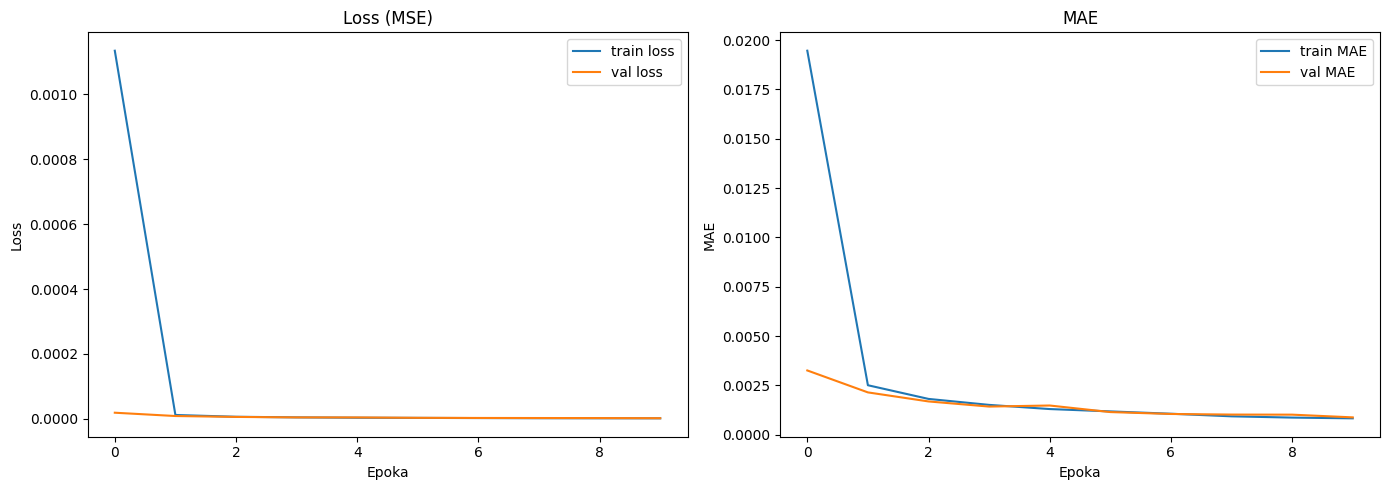

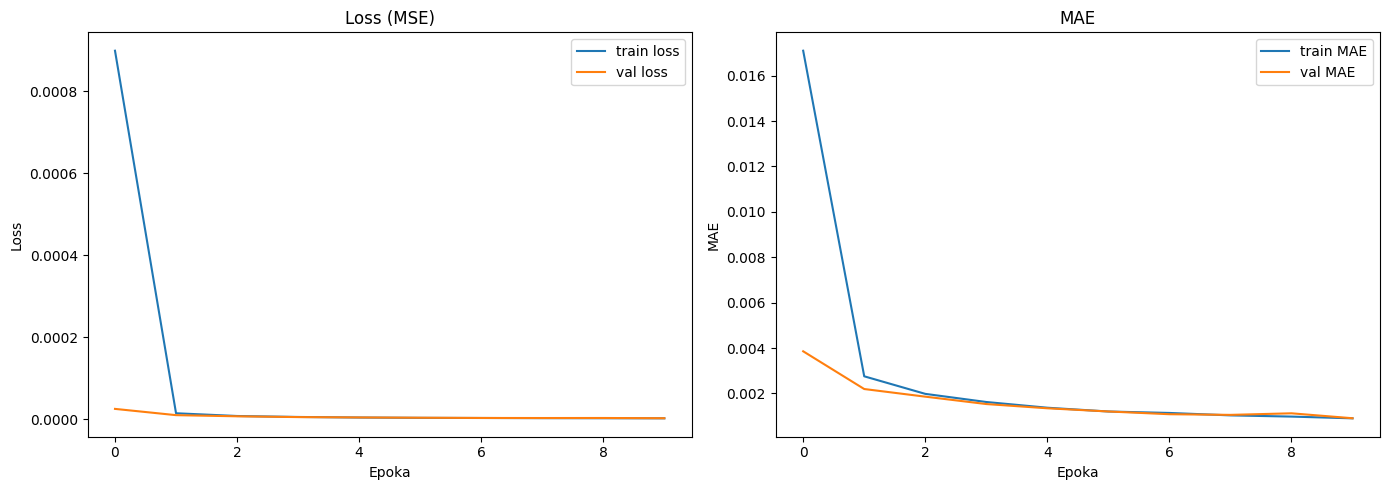

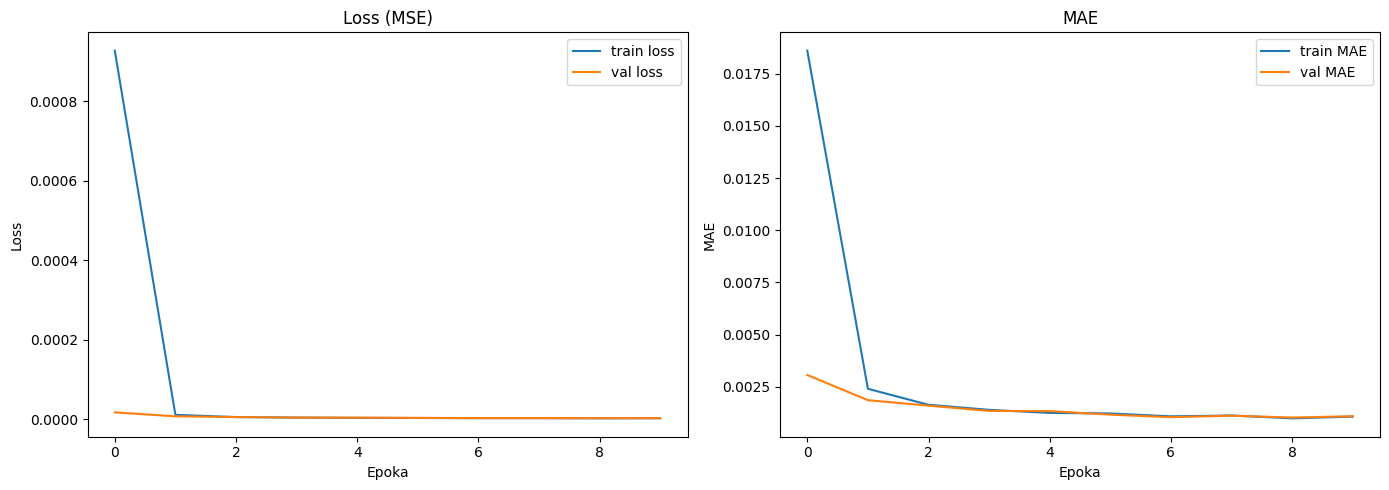

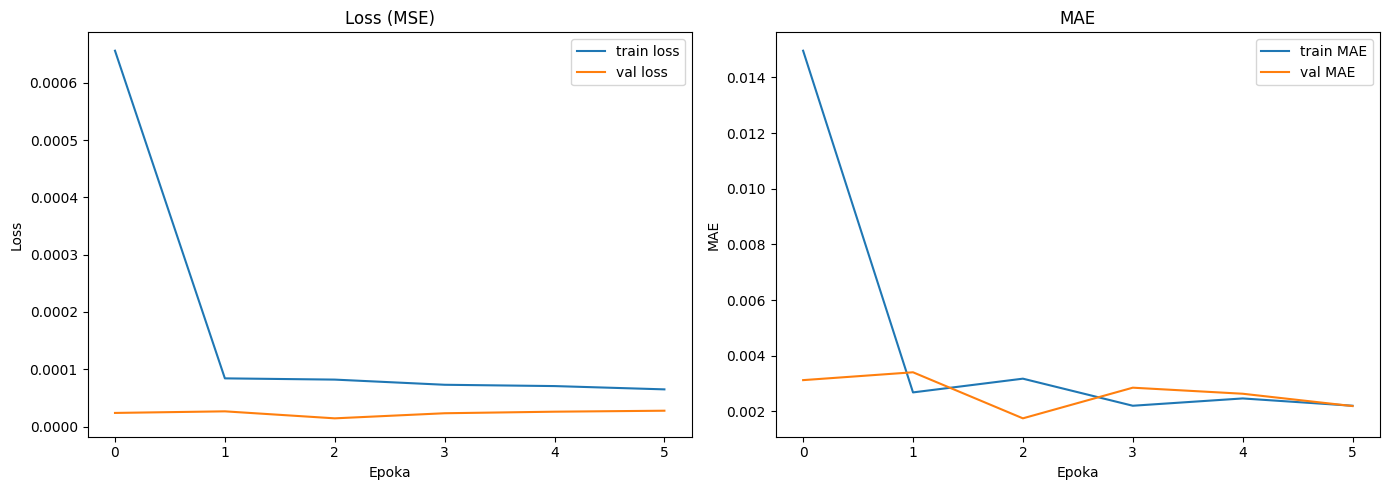

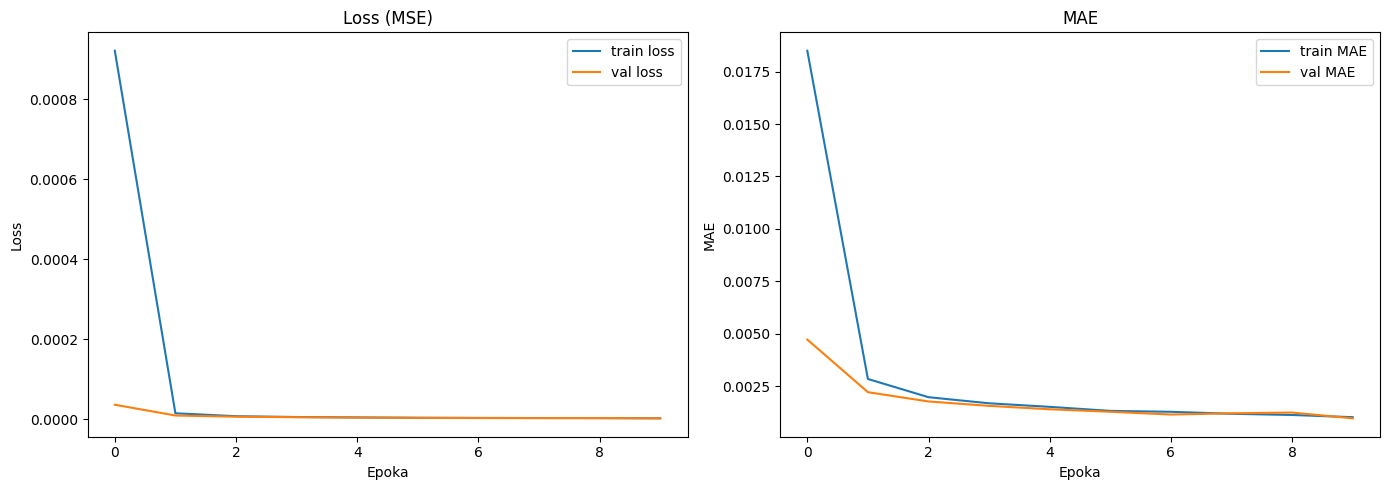

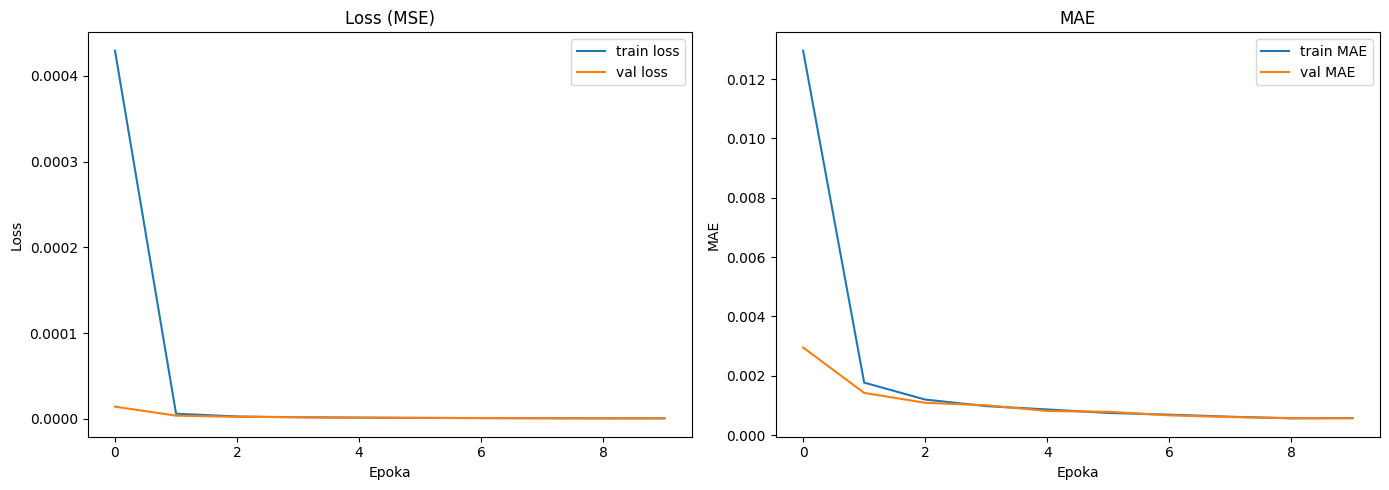

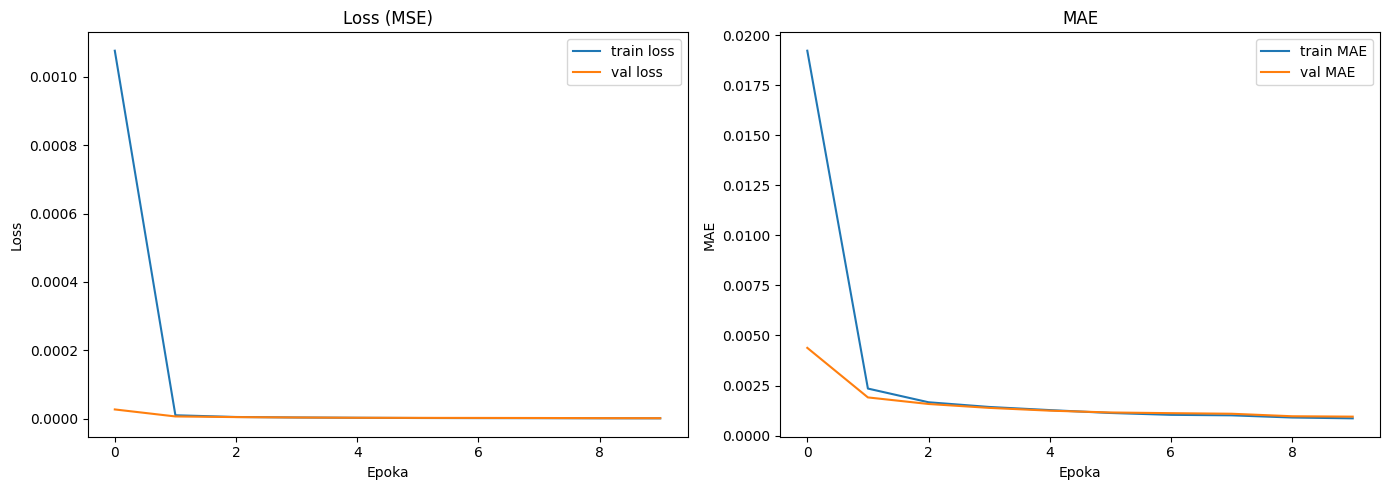

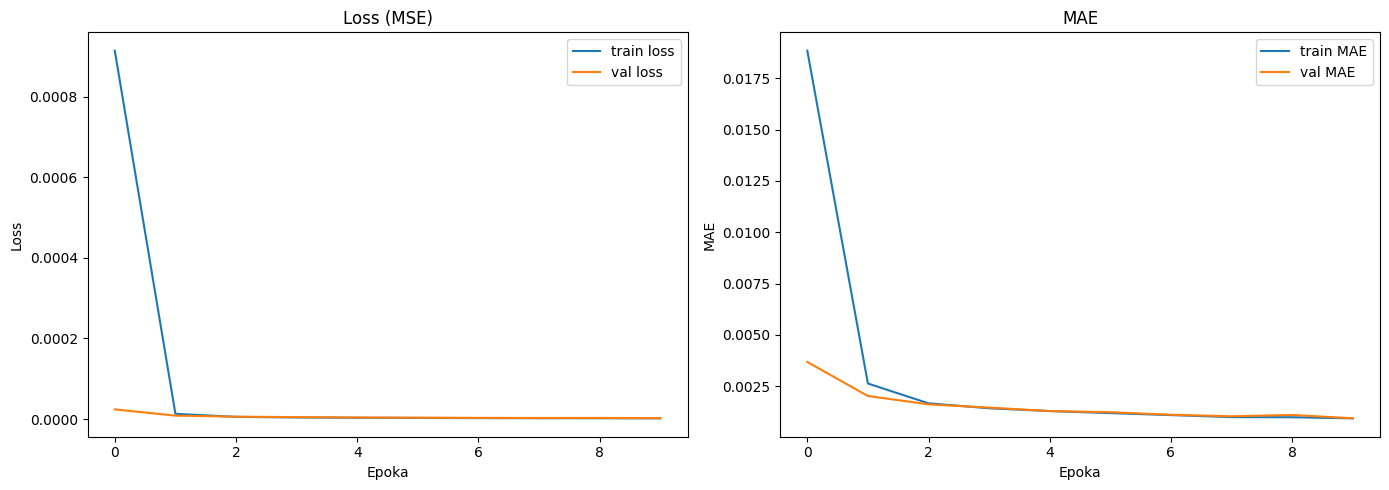

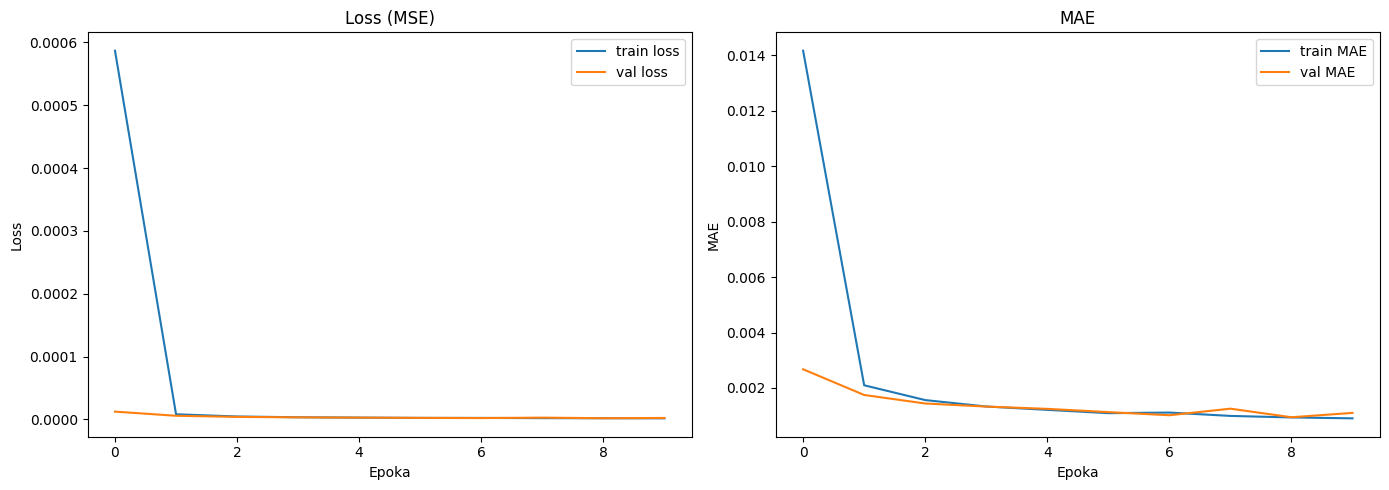

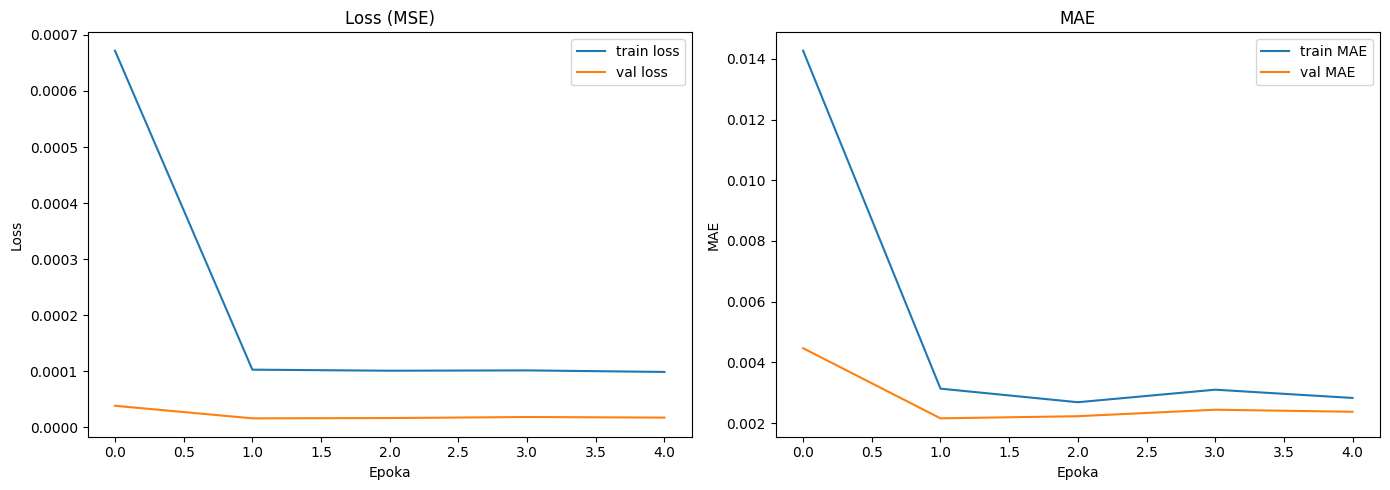

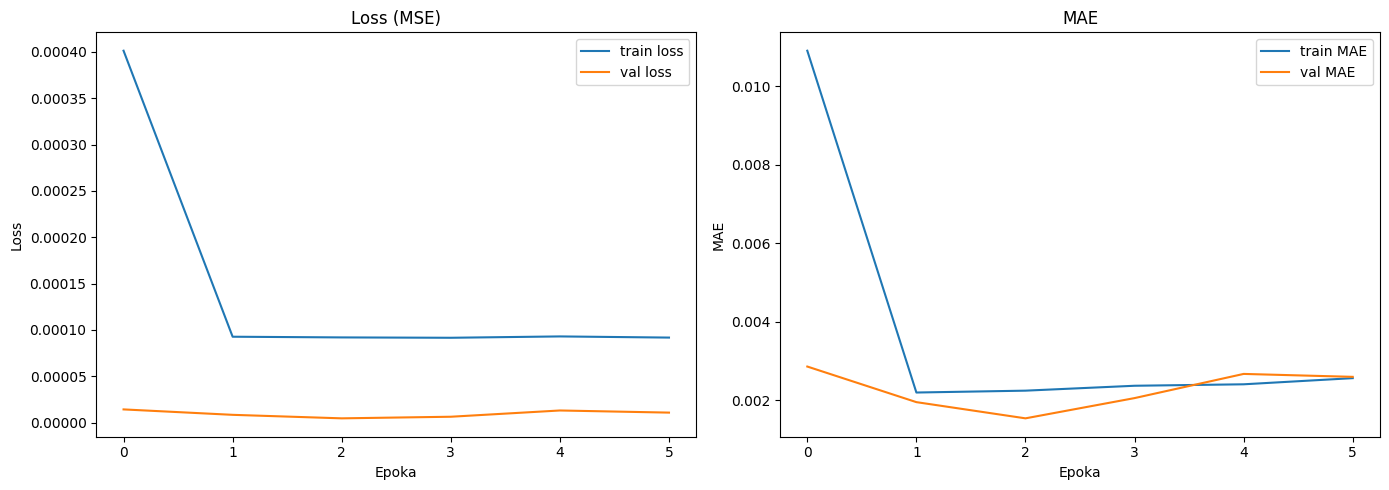

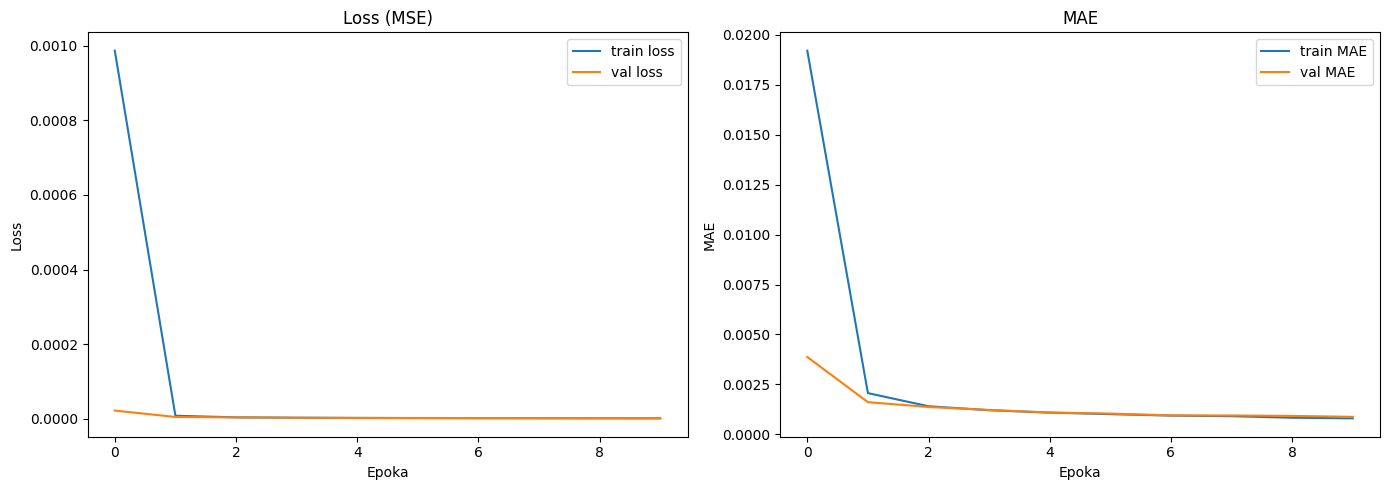

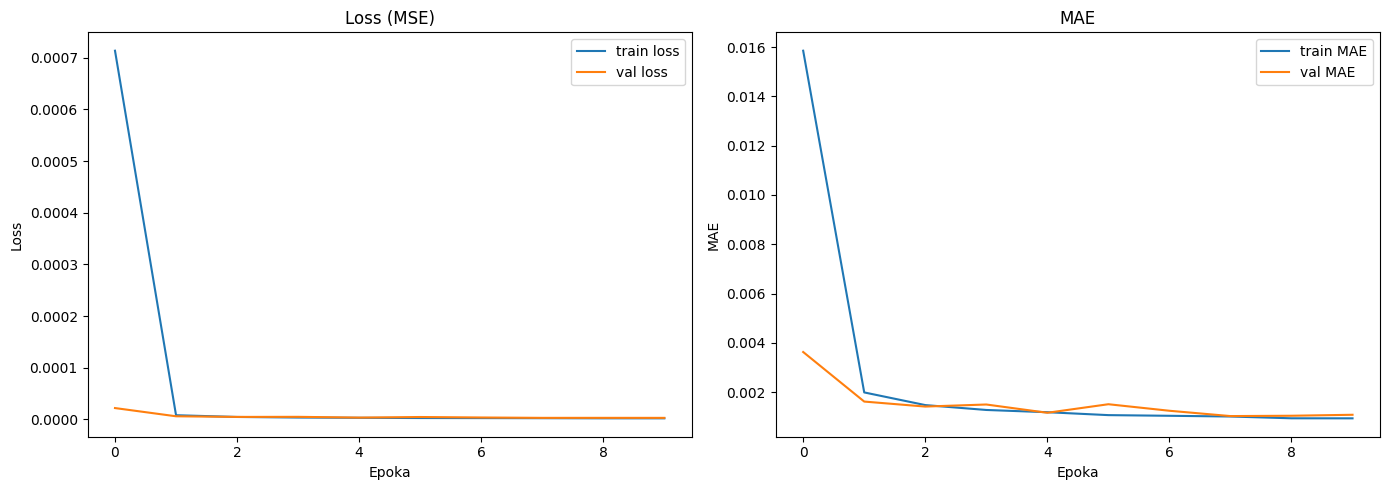

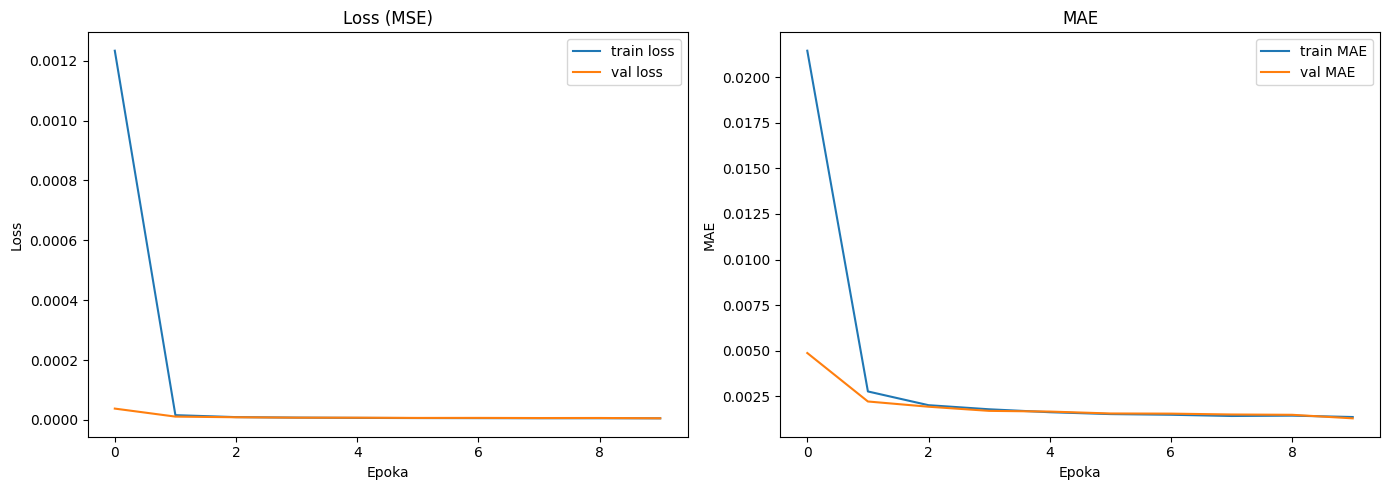

In [6]:
for i in range(1,15):
    history = historis[10 * i]
    plt.figure(figsize=(14,5))
    # ------ Loss ---------
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="val loss")
    plt.title("Loss (MSE)")
    plt.xlabel("Epoka")
    plt.ylabel("Loss")
    plt.legend()

    # ------ MAE ----------
    plt.subplot(1,2,2)
    plt.plot(history.history["mae"], label="train MAE")
    plt.plot(history.history["val_mae"], label="val MAE")
    plt.title("MAE")
    plt.xlabel("Epoka")
    plt.ylabel("MAE")
    plt.legend()

    plt.tight_layout()
    plt.show()